In [1]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 

# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.9.1


# *Data Prep*

Training and Testing data is prepared from the solution file

In [2]:
## Data Import
K_real = np.load('./K_tx_real_d_one.npy') # Values of K(t,x)
Q_real = np.load('./Q_15minutes.npy') # Input Matrix of Model
f_real = Q_real[:,1] # Inflow Rate
v_real = Q_real[:,3] # Average Speed
pi_real = np.load('./pitilde_15minutes.npy') # Values of pi(t,x)

In [3]:
pi_real.shape

(150, 2016)

Text(0, 0.5, 'Remaining Trip Distance (miles)')

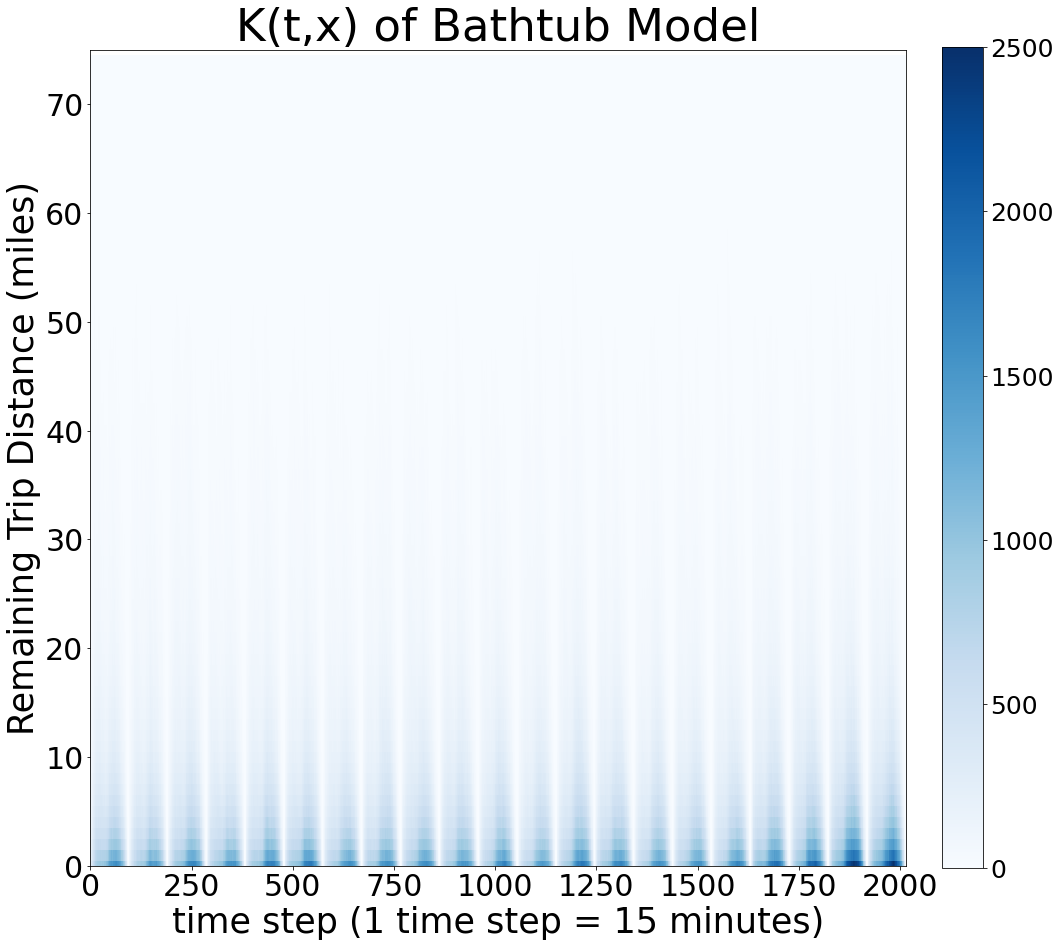

In [4]:
K_array = np.array(K_real[:,0:len(K_real[0])])
fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.T, cmap = 'Blues', interpolation='nearest')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,len(K_real[0])])
plt.clim(0, 2500) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title('K(t,x) of Bathtub Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (miles)', fontsize=35)

In [5]:
## Scale
N_timestep = 24*21*4 # 24 hours * 21 days * 15 minutes = total timestep
N_diststep = 75 # 1 distance step = 1 mile
Size_diststep = 1 # unit: miles
N_trainingdays = 0 # Set zero (0)
N_training = 24*4*N_trainingdays # Training data is all


## Normalization [0,1]
x = np.arange(0,int(N_diststep/Size_diststep))[:,None]   # x: step of remaining distance
t = np.arange(0,N_timestep)[:,None]    # Time step 
usol = K_real.transpose() [:,N_training:]     # real value of K(t,x) ==> Target Variable
usol_max = usol.max()

## Normalization [0,1]
x = (x - x.min()) / (x.max() - x.min())
t = (t - t.min()) / (t.max() - t.min())
f_real = (f_real - usol.min()) / (usol.max() - usol.min())  # usol과 같은 dimension이어야 함. 단위 같기 때문.
v_real = (v_real - v_real.min()) / (v_real.max() - v_real.min())
usol = (usol - usol.min()) / (usol.max()-usol.min())

X, T = np.meshgrid(x,t)                     # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple


multiplier_dist = int(N_diststep/Size_diststep)-1
multiplier_time = N_timestep-1
multiplier_u = usol_max
print('multiplier distance = ', multiplier_dist)
print('multiplier time = ', multiplier_time)
print('usol max = ', usol_max)

multiplier distance =  74
multiplier time =  2015
usol max =  2500


In [6]:
Size_diststep = 15 # unit: miles
size_input = int(N_diststep/Size_diststep)*N_timestep # Total number of grid points
# size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
N_u = int(size_input*0.2) # Total number of data points for 'u' ==> Training data from grid points
N_f = N_u*2 #Total number of collocation (auxiliary) points 
alpha = 0.5 # weights of loss

print('size input = ', size_input)
print('N_u = ', N_u)
print('N_f = ', N_f)

size input =  10080
N_u =  2016
N_f =  4032


In [7]:
# # Previous version (before Aug 30)
# size_input = int(N_diststep/Size_diststep)*N_timestep # All domain
# # size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
# N_u = int(size_input*0.5) #Total number of data points for 'u'
# N_f = N_u*2 #Total number of collocation points 
# alpha = 0.5

# print('size input = ', size_input)
# print('N_u = ', N_u)
# print('N_f = ', N_f)

# *Grid Data*

We prepare the grid data to compare against the solution produced by the PINN.

In [8]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_u_grid = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_u_grid[0]  # [-1. 0.]
ub = X_u_grid[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
u_grid = usol.flatten('F')[:,None] 

# *Training Data* (All domain)


The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

In [9]:
def trainingdata(N_u,N_f):

#     '''Boundary Conditions'''

#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 0  
#     leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
#     leftedge_u = usol[:,0][:,None]
    
#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 2015  
#     rightedge_x = np.hstack((X[0,:][:,None], T[-1,:][:,None])) #L1
#     rightedge_u = usol[:,-1][:,None]

#     #Boundary Condition x = 9 (135 miles) and 0 =< t =<2015
#     topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
#     topedge_u = usol[-1,:][:,None]
        
#     #Boundary Condition x = 0 and 0 =< t =<2015
#     bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
#     bottomedge_u = usol[0,:][:,None]
    
#     #Boundary Condition x = 5 (25 miles) and 0 =< t =<2015
#     midedge_x = np.hstack((X[:,5][:,None], T[:,0][:,None])) #L3
#     midedge_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 10 (50 miles) and 0 =< t =<2015
#     midedge1_x = np.hstack((X[:,10][:,None], T[:,0][:,None])) #L3
#     midedge1_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 15 (75 miles) and 0 =< t =<2015
#     midedge2_x = np.hstack((X[:,15][:,None], T[:,0][:,None])) #L3
#     midedge2_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 20 (100 miles) and 0 =< t =<2015
#     midedge3_x = np.hstack((X[:,20][:,None], T[:,0][:,None])) #L3
#     midedge3_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 25 (125 miles) and 0 =< t =<2015
#     midedge4_x = np.hstack((X[:,25][:,None], T[:,0][:,None])) #L3
#     midedge4_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 2 and 0 =< t =<2015
#     bottomedge_x_2 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_2 = usol[2,:][:,None]
    
#     #Boundary Condition x = 1 and 0 =< t =<2015
#     bottomedge_x_1 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_1 = usol[1,:][:,None]


#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x, midedge1_x, midedge2_x, midedge3_x, midedge4_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u, midedge1_u, midedge2_u, midedge3_u, midedge4_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([bottomedge_x, bottomedge_x_1, bottomedge_x_2]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, bottomedge_u_1, bottomedge_u_2])   #corresponding u [4042,]
    
#     all_X_u_train = np.vstack([bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, topedge_u])   #corresponding u [4042,]

    all_X_u_train = np.hstack((X.T[range(0,N_diststep,Size_diststep)].flatten()[:,None],T.T[range(0,N_diststep,Size_diststep)].flatten()[:,None]))
    all_u_train = usol[range(0,N_diststep,Size_diststep)].flatten()[:,None]
    
    #choose random N_u points for training
    np.random.seed(1234)
    train_idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) # ID of training data
    test_idx = np.delete(np.arange(size_input), train_idx) # ID of testing data
    
    # Training Data
    X_u_train = all_X_u_train[train_idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[train_idx,:]      #choose corresponding u
    
    # Testing Data
    X_u_test = all_X_u_train[test_idx, :]
    u_test = all_u_train[test_idx,:]

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
#     X_f_train = np.rint(lb + (ub-lb)*lhs(2,N_f))
    X_f_train = (lb + (ub-lb)*lhs(2,N_f))
#     X_f_train = np.unique(X_f_train, axis=0).astype(int) # 중복된 것 없앰
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 
    
    f_t = f_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    pi_tx = pi_real[np.int0(X_f_train*multiplier_dist)[:,0],np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    v_t = v_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]

    return X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx

In [10]:
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)

In [11]:
X_u_train.shape

(2016, 2)

In [12]:
X_u_test.shape

(8064, 2)

In [13]:
X_u_train

array([[0.81081081, 0.98163772],
       [0.60810811, 0.21042184],
       [0.40540541, 0.29280397],
       ...,
       [0.        , 0.54739454],
       [0.81081081, 0.10322581],
       [0.40540541, 0.32754342]])

# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [14]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):
       
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        
        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim
    
    def evaluate(self,x):
        
        x = (x-lb)/(ub-lb)
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return a
    
#     def speed(self,x):
        
#         a = tf.math.minimum(u_free, tf.abs(a_speed/x + b_speed))

#         print('speed = ', a)
#         print('k = ', x)

#         return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    def loss_BC(self,x,y):

        loss_u = tf.reduce_mean(tf.square(y-self.evaluate(x)))
        return loss_u
    
    def loss(self,x,y):

        loss_u = self.loss_BC(x,y)

        loss = loss_u

        return loss, loss_u
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u= self.loss(X_u_train, u_train)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
               
        loss_value, loss_u = self.loss(X_u_train, u_train)
        
        u_pred = self.evaluate(X_u_test)
        error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)
        loss_record.append(loss_value)
        l2_record.append(error_vec)
        
        tf.print(loss_value, loss_u, error_vec)

# *Model Training and Testing*

A function '**model**' is defined to generate a NN as per the input set of hyperparameters, which is then trained and tested. The L2 Norm of the solution error is returned as a comparison metric

In [15]:
# Training data
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)
#alpha = int(N_f/N_u) #weight of loss function

layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers
loss_record = []
l2_record = []

PINN = Sequentialmodel(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 100, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
#                                             'ftol': 1e-10,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 1e-10, 
                                            'maxfun':  50000, 
                                            'maxiter': 15000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})
end_time = time.time()

0.030024677879431774 0.030024677879431774 0.8087455913131856
0.024724372865136054 0.024724372865136054 0.7362360336879908
0.0205906679369018 0.0205906679369018 0.6731245011298855
0.020245515499008424 0.020245515499008424 0.6654316480228624
0.019959491245997676 0.019959491245997676 0.6580941421096057
0.019778086085041623 0.019778086085041623 0.6539817053562381
0.019121043808607876 0.019121043808607876 0.6401822238431507
0.018407401921321689 0.018407401921321689 0.6258639661767669
0.01738096047490922 0.01738096047490922 0.608617729028386
0.016365046313839261 0.016365046313839261 0.5940195607949681
0.016137929147763568 0.016137929147763568 0.5928668943524358
0.015825110158578563 0.015825110158578563 0.5863273077979544
0.01571648171853637 0.01571648171853637 0.5838025933860396
0.01532475745691452 0.01532475745691452 0.5740063204457173
0.0149241990149837 0.0149241990149837 0.5640060742564622
0.014358554826045245 0.014358554826045245 0.5508430320418747
0.013197250917672754 0.0131972509176727

0.0085778470201568757 0.0085778470201568757 0.42495737468426664
0.0085770215116172527 0.0085770215116172527 0.42524621494303616
0.0085764044442405273 0.0085764044442405273 0.4252227963477992
0.0085758978643220869 0.0085758978643220869 0.4250474624322788
0.0085758090547854177 0.0085758090547854177 0.424978488632046
0.0085757897060876141 0.0085757897060876141 0.4249515345142659
0.0085757846957526789 0.0085757846957526789 0.42493958691360917
0.0085757792821868958 0.0085757792821868958 0.42492347123569346
0.0085757714430726682 0.0085757714430726682 0.42490895428242004
0.0085757483634309271 0.0085757483634309271 0.4248813012581891
0.00857569343327474 0.00857569343327474 0.4248394595170119
0.00857555954589327 0.00857555954589327 0.42477377226330093
0.0085752685879985861 0.0085752685879985861 0.4246890454010944
0.008574671178222297 0.008574671178222297 0.42461447324327184
0.0085738342693970869 0.0085738342693970869 0.42466035890844306
0.00857325847306368 0.00857325847306368 0.4247168746122299

0.0085674987016113712 0.0085674987016113712 0.4247457248967177
0.0085674501103539212 0.0085674501103539212 0.42465151061337497
0.0085674104459543647 0.0085674104459543647 0.42461882902485426
0.008567363687106774 0.008567363687106774 0.42470065255736666
0.008567347404361738 0.008567347404361738 0.4246703147840781
0.0085673031379655054 0.0085673031379655054 0.4246663751766898
0.0085672822615206028 0.0085672822615206028 0.424666774833107
0.0085672541186505788 0.0085672541186505788 0.42468739166781155
0.0085672411013552816 0.0085672411013552816 0.4246708521987585
0.0085672263235533116 0.0085672263235533116 0.42470370497484466
0.0085672205725103555 0.0085672205725103555 0.424668518847978
0.008567218133684924 0.008567218133684924 0.42471739440978096
0.0085672157137811535 0.0085672157137811535 0.4247103040806292
0.0085672143129112387 0.0085672143129112387 0.42470125102651063
0.008567213292229852 0.008567213292229852 0.4247032707495312
0.0085672120771991232 0.0085672120771991232 0.424706187178

0.0083445479679378209 0.0083445479679378209 0.4251274642554437
0.00833803709347539 0.00833803709347539 0.42485959807524465
0.0083314961891041 0.0083314961891041 0.42453311250379866
0.0083275767666752924 0.0083275767666752924 0.4240360914221364
0.0083204053188578233 0.0083204053188578233 0.42440894390408007
0.008315355902744093 0.008315355902744093 0.424561803714355
0.0083124974104286323 0.0083124974104286323 0.42421715496796786
0.0083118431820348847 0.0083118431820348847 0.42390675890074675
0.0083092764672515369 0.0083092764672515369 0.42394775916926036
0.0083065773376919342 0.0083065773376919342 0.424086631056198
0.0083041564058510056 0.0083041564058510056 0.42374327448832655
0.0083039844753915182 0.0083039844753915182 0.4238039153852296
0.0083026604461896546 0.0083026604461896546 0.4236240932407249
0.0083022218278428917 0.0083022218278428917 0.42388456097869165
0.0083018635284965725 0.0083018635284965725 0.4239205698612106
0.0083009967739867668 0.0083009967739867668 0.424139775589586

0.00818930932737037 0.00818930932737037 0.42266916466021043
0.0081882832885873252 0.0081882832885873252 0.4224473298564813
0.008187770202966382 0.008187770202966382 0.42221260620071344
0.0081868610204497549 0.0081868610204497549 0.42220265437318
0.0081850302596752 0.0081850302596752 0.42244982461364644
0.0081825758693977544 0.0081825758693977544 0.4223746867095648
0.00818146273907378 0.00818146273907378 0.4224166944448632
0.0081803240563647472 0.0081803240563647472 0.4222850849968392
0.008177330582628017 0.008177330582628017 0.42228845074125765
0.00817480089018554 0.00817480089018554 0.4220205926501485
0.0081727359937950172 0.0081727359937950172 0.4220066112017663
0.008166616692514516 0.008166616692514516 0.42093288628200903
0.0081652687375133124 0.0081652687375133124 0.421174277983995
0.0081633644290492573 0.0081633644290492573 0.42108602698826614
0.008161632576797008 0.008161632576797008 0.4209088876712844
0.0081608329036867763 0.0081608329036867763 0.42066833738756054
0.008159328093

0.0080041192411402767 0.0080041192411402767 0.41688336373253354
0.00800217519325704 0.00800217519325704 0.41735520923622876
0.0079994215919086849 0.0079994215919086849 0.41693985439270775
0.0079978334324368218 0.0079978334324368218 0.41683910461862034
0.0079967567365528472 0.0079967567365528472 0.41660576090279106
0.0079956297252144742 0.0079956297252144742 0.4164408052748791
0.0079935633884943586 0.0079935633884943586 0.41633083820347866
0.0079918122273167826 0.0079918122273167826 0.41664452614964376
0.0079908237052835982 0.0079908237052835982 0.41654766781464675
0.007990327348429067 0.007990327348429067 0.4167239059225537
0.0079894668259094 0.0079894668259094 0.4171212488396227
0.0079889361150290317 0.0079889361150290317 0.417037305443777
0.0079883785162527653 0.0079883785162527653 0.4170850931400827
0.007988047899143683 0.007988047899143683 0.4170499359801687
0.00798755655225492 0.00798755655225492 0.41725385702659484
0.00798689898841046 0.00798689898841046 0.41732429549306216
0.007

0.0078005103309464908 0.0078005103309464908 0.4175834477550668
0.0077965694881387965 0.0077965694881387965 0.41766647552775016
0.0077940746498773444 0.0077940746498773444 0.4172865312580104
0.0077920791346715442 0.0077920791346715442 0.4174748972197593
0.0077904285208492694 0.0077904285208492694 0.41741102700141736
0.0077878556052222749 0.0077878556052222749 0.4173842202582045
0.0077851147085232072 0.0077851147085232072 0.4172221694915205
0.0077814728127849021 0.0077814728127849021 0.41723601475862754
0.00777815362235609 0.00777815362235609 0.4170951709832983
0.0077756888073090107 0.0077756888073090107 0.41668937379468307
0.0077724735931799819 0.0077724735931799819 0.41623561700328143
0.00776931346104684 0.00776931346104684 0.4158699472882078
0.0077660059530948507 0.0077660059530948507 0.41542812830081227
0.0077632332348764694 0.0077632332348764694 0.41559734198744075
0.0077615090518642878 0.0077615090518642878 0.4156265120223956
0.0077604565311272 0.0077604565311272 0.4161268044541913

0.0076898949737598341 0.0076898949737598341 0.41034362294222465
0.0076891562742254426 0.0076891562742254426 0.4101664830800179
0.0076890719406237677 0.0076890719406237677 0.41025281510210904
0.0076887466377017375 0.0076887466377017375 0.41023908194399056
0.0076886787722432537 0.0076886787722432537 0.4102846044521914
0.0076885528930363623 0.0076885528930363623 0.4102520164975708
0.00768846877204481 0.00768846877204481 0.4102962438470775
0.0076883754345092479 0.0076883754345092479 0.41030534625580706
0.0076882058371851164 0.0076882058371851164 0.41032241720049395
0.0076880639530036267 0.0076880639530036267 0.41035360396118054
0.0076877777838675 0.0076877777838675 0.4103780203319604
0.0076874853103058192 0.0076874853103058192 0.4104578434923612
0.0076870711576212105 0.0076870711576212105 0.41041500453688423
0.0076866723587584434 0.0076866723587584434 0.41042442436674337
0.0076862079663984322 0.0076862079663984322 0.41042969409656627
0.0076858984592461021 0.0076858984592461021 0.4104484354

0.0076678298586896412 0.0076678298586896412 0.4105657152636652
0.0076676334176173011 0.0076676334176173011 0.41046801759843754
0.0076674649814628031 0.0076674649814628031 0.41053517081657803
0.0076670638056878715 0.0076670638056878715 0.41066349848959377
0.0076668830237916754 0.0076668830237916754 0.4106111155122293
0.007666737630693375 0.007666737630693375 0.41062594861575463
0.0076665899836253458 0.0076665899836253458 0.4105967392147735
0.0076663299080597207 0.0076663299080597207 0.4104040541799312
0.0076662125391269509 0.0076662125391269509 0.41035486612416505
0.0076661308558535739 0.0076661308558535739 0.4103164857374604
0.0076660409312020094 0.0076660409312020094 0.410322177563062
0.0076659875306690833 0.0076659875306690833 0.41040106365590573
0.0076659099250309037 0.0076659099250309037 0.41039258892913527
0.0076658322548185578 0.0076658322548185578 0.4104351365469794
0.0076657888473777528 0.0076657888473777528 0.4104612653021707
0.0076657495277702428 0.0076657495277702428 0.41049

0.0076543529203564583 0.0076543529203564583 0.41153719347227974
0.007654202936897482 0.007654202936897482 0.4115194947403558
0.0076541125679973863 0.0076541125679973863 0.4116075997453264
0.0076540053238154113 0.0076540053238154113 0.41160344826571094
0.0076539357607254077 0.0076539357607254077 0.41157024085403676
0.007653878343844905 0.007653878343844905 0.4114893027205916
0.0076538432417728765 0.0076538432417728765 0.4115195186293948
0.0076537975254438945 0.0076537975254438945 0.41148262479930264
0.007653773423751252 0.007653773423751252 0.4114451392550879
0.0076537598456209843 0.0076537598456209843 0.41142818874643167
0.0076537470136935955 0.0076537470136935955 0.4114060775092934
0.0076537190656956484 0.0076537190656956484 0.4114297663243678
0.0076536771110035382 0.0076536771110035382 0.41142099721278474
0.0076536037580165394 0.0076536037580165394 0.4115001090967194
0.0076535029234648371 0.0076535029234648371 0.41150910460736706
0.0076533987292056582 0.0076533987292056582 0.41149446

0.0076425597713022549 0.0076425597713022549 0.41088359050623036
0.0076425431804356238 0.0076425431804356238 0.41083834202306857
0.0076425104376688143 0.0076425104376688143 0.41081697200032197
0.0076424740117116184 0.0076424740117116184 0.41081309492079904
0.0076424360982427515 0.0076424360982427515 0.41079604660584196
0.007642391598435193 0.007642391598435193 0.41077033570040206
0.0076423545546842183 0.0076423545546842183 0.4108022522025361
0.0076422940965345468 0.0076422940965345468 0.41073046307018624
0.00764227815261258 0.00764227815261258 0.4106486189146247
0.007642237582101483 0.007642237582101483 0.4106780664262676
0.0076422078107083154 0.0076422078107083154 0.4106715425658294
0.0076421965748505565 0.0076421965748505565 0.4106567738785684
0.007642183689933392 0.007642183689933392 0.4106168982345578
0.00764216175882375 0.00764216175882375 0.4106001956395947
0.007642130564935172 0.007642130564935172 0.41053886662337336
0.00764209522922416 0.00764209522922416 0.41052478590098285
0.0

0.0076265595161075254 0.0076265595161075254 0.4075818203022787
0.0076265007300043595 0.0076265007300043595 0.4076392718162777
0.0076264129417552475 0.0076264129417552475 0.40762867081279164
0.007626244357436974 0.007626244357436974 0.4076008141420978
0.0076260331874010313 0.0076260331874010313 0.4075002197679565
0.0076259258167275974 0.0076259258167275974 0.4074609821941598
0.0076257625895956322 0.0076257625895956322 0.40746139854209557
0.0076256529274463985 0.0076256529274463985 0.4074688848631861
0.0076255041674302545 0.0076255041674302545 0.4074024558481451
0.0076253465798107748 0.0076253465798107748 0.4074412265499864
0.0076251737968445763 0.0076251737968445763 0.4075457873332576
0.0076249260805698708 0.0076249260805698708 0.4075374950056347
0.0076246281779563828 0.0076246281779563828 0.4075649064114325
0.00762435292337293 0.00762435292337293 0.4075579046473913
0.00762414438144864 0.00762414438144864 0.40754918332644835
0.0076239808475494159 0.0076239808475494159 0.4075853037632709

0.0076053578869852059 0.0076053578869852059 0.40528331886112556
0.0076051274461248772 0.0076051274461248772 0.40541162849410867
0.0076048160471554249 0.0076048160471554249 0.40529787660599126
0.0076046704802416988 0.0076046704802416988 0.4052705964034157
0.0076045580418083241 0.0076045580418083241 0.4052369232769408
0.0076045054009047037 0.0076045054009047037 0.405187375141442
0.0076043639402655471 0.0076043639402655471 0.4052209989746047
0.007604281263853074 0.007604281263853074 0.40518461237168657
0.0076040445527333954 0.0076040445527333954 0.40511934074371786
0.0076038945532845847 0.0076038945532845847 0.40497011704624036
0.0076035555641993779 0.0076035555641993779 0.404921386882505
0.0076033535003991138 0.0076033535003991138 0.40489950301109406
0.007603244592667876 0.007603244592667876 0.4048011746510893
0.007603004711814066 0.007603004711814066 0.404903059646591
0.0076027754782765616 0.0076027754782765616 0.40486474193815597
0.0076024690517113658 0.0076024690517113658 0.4047564099

0.0075796651418017459 0.0075796651418017459 0.40200443507258915
0.0075793479165710406 0.0075793479165710406 0.401989092126655
0.0075791587959022312 0.0075791587959022312 0.40199454160467807
0.0075790080335898929 0.0075790080335898929 0.40205414611810203
0.0075788520159445648 0.0075788520159445648 0.4017984198618765
0.0075786517724348154 0.0075786517724348154 0.40195521279110524
0.0075786102122169935 0.0075786102122169935 0.4019055063917873
0.007578456611487365 0.007578456611487365 0.4019016882740122
0.0075783696681867123 0.0075783696681867123 0.40183201713212274
0.0075783113998321361 0.0075783113998321361 0.4018394655125697
0.0075781994115905775 0.0075781994115905775 0.4018003018624431
0.007578087643734471 0.007578087643734471 0.4018324912847694
0.0075779966510459672 0.0075779966510459672 0.40175303730483675
0.0075779214473951657 0.0075779214473951657 0.4018253390646463
0.0075778652200747636 0.0075778652200747636 0.40182507397893497
0.0075777723981117059 0.0075777723981117059 0.4017801

0.0075460160992651725 0.0075460160992651725 0.4025378916365405
0.0075456065094294707 0.0075456065094294707 0.4025825876564227
0.0075453278516990855 0.0075453278516990855 0.40247488513909085
0.007545143730512671 0.007545143730512671 0.4023974943767058
0.0075448178196589073 0.0075448178196589073 0.4023965103431101
0.0075446525213162694 0.0075446525213162694 0.40233422059200863
0.0075442967159539765 0.0075442967159539765 0.40221405070102145
0.0075440683850181017 0.0075440683850181017 0.4022110412226211
0.0075438720751276672 0.0075438720751276672 0.40221665692162034
0.007543697549665454 0.007543697549665454 0.4022019173635776
0.007543407402036191 0.007543407402036191 0.4022486541849237
0.0075432286667603682 0.0075432286667603682 0.4022731076500988
0.0075430635258268508 0.0075430635258268508 0.4023970232205842
0.0075429621489447379 0.0075429621489447379 0.40241028829920444
0.0075427866891223357 0.0075427866891223357 0.40241354061066215
0.0075426099378282374 0.0075426099378282374 0.402405185

0.0075055441014255332 0.0075055441014255332 0.40299576522311037
0.0075048706358795438 0.0075048706358795438 0.4032444902411932
0.0075044860868736848 0.0075044860868736848 0.4028159518500861
0.0075038166264249032 0.0075038166264249032 0.402443956411709
0.0075034682731436684 0.0075034682731436684 0.4027700644134782
0.0075028920403780357 0.0075028920403780357 0.4025423001830363
0.0075025090197313191 0.0075025090197313191 0.4021536134895408
0.0075020033145845972 0.0075020033145845972 0.402150950373404
0.007501154098284642 0.007501154098284642 0.402149065737434
0.0075003762969531795 0.0075003762969531795 0.4017551700832769
0.007499667729680152 0.007499667729680152 0.4017512459840599
0.00749889443351462 0.00749889443351462 0.40177721350110274
0.0074982448250080621 0.0074982448250080621 0.40196680340088903
0.0074980697808629286 0.0074980697808629286 0.40182674803227847
0.0074976587112915629 0.0074976587112915629 0.40196163315342837
0.0074971882774061459 0.0074971882774061459 0.401632960975008

0.0074104640972838887 0.0074104640972838887 0.3960971489219658
0.0074091088708514528 0.0074091088708514528 0.39593679048701236
0.0074077436672900432 0.0074077436672900432 0.396328604641767
0.00740626774558551 0.00740626774558551 0.3958071044915025
0.0074061483019350451 0.0074061483019350451 0.39595674087715804
0.0074051727650965614 0.0074051727650965614 0.3961548611280087
0.0074037967589896453 0.0074037967589896453 0.3958599488999237
0.00740318568474339 0.00740318568474339 0.39577985807648414
0.0074022023432630014 0.0074022023432630014 0.39566998986714624
0.007400870663293921 0.007400870663293921 0.3955776942755412
0.007400191541960627 0.007400191541960627 0.39568900685704794
0.0073996076246547965 0.0073996076246547965 0.3950016200639159
0.0073982630954086736 0.0073982630954086736 0.39534597639121366
0.00739768287689897 0.00739768287689897 0.39522984493646585
0.0073970726764636405 0.0073970726764636405 0.39512654409313397
0.0073966399451345817 0.0073966399451345817 0.3951220327303689
0

0.0073149526817909861 0.0073149526817909861 0.3938434120320097
0.0073141082933075186 0.0073141082933075186 0.3939002588831811
0.0073130013872563984 0.0073130013872563984 0.39395763522193683
0.0073120231351321572 0.0073120231351321572 0.39418383944196533
0.00731133257072161 0.00731133257072161 0.3943464663135139
0.0073108611313041439 0.0073108611313041439 0.3938456337690329
0.0073099330457424968 0.0073099330457424968 0.3940243849262374
0.0073092624040539261 0.0073092624040539261 0.3942998827294227
0.007308569071438533 0.007308569071438533 0.3943549671703802
0.0073075619207021566 0.0073075619207021566 0.3943415765464194
0.0073073004638119126 0.0073073004638119126 0.3944225283907025
0.0073066795730433245 0.0073066795730433245 0.39450046227171154
0.0073064067856713757 0.0073064067856713757 0.3945472340886722
0.0073060395552411866 0.0073060395552411866 0.39446840340740585
0.00730582291660466 0.00730582291660466 0.3945067167102499
0.0073056550631719957 0.0073056550631719957 0.394581860579454

0.0072753802451833742 0.0072753802451833742 0.9998051341697405
0.0072750489847911862 0.0072750489847911862 1.0529851817291125
0.0072746315115619874 0.0072746315115619874 1.1679096972527019
0.007274283864571688 0.007274283864571688 1.1969076173993636
0.0072740398083245509 0.0072740398083245509 1.3472867709113556
0.0072737850553855057 0.0072737850553855057 1.3964463042689916
0.0072733654809664363 0.0072733654809664363 1.4552075592514275
0.0072731665506277458 0.0072731665506277458 1.5766764769163968
0.0072729170029145734 0.0072729170029145734 1.7127027680414353
0.007272809177019334 0.007272809177019334 1.7828502350304418
0.0072726836007548047 0.0072726836007548047 1.8466357290493736
0.007272563216660451 0.007272563216660451 1.7848592459794301
0.0072724514421069327 0.0072724514421069327 1.8431590974446643
0.007272387678875605 0.007272387678875605 1.8999328327444678
0.0072723520964491023 0.0072723520964491023 1.8946871398336944
0.0072722801991882326 0.0072722801991882326 1.9265427194484335


0.0072478844032144284 0.0072478844032144284 3.1816647461510907
0.0072477327302266836 0.0072477327302266836 3.1702934990847105
0.0072476226037042043 0.0072476226037042043 3.179361728060496
0.007247521669283781 0.007247521669283781 3.193072835385754
0.0072473674958307387 0.0072473674958307387 3.2144117617035284
0.0072472497021807986 0.0072472497021807986 3.2718970041819455
0.0072470693550507484 0.0072470693550507484 3.2727648873614354
0.0072468635123947344 0.0072468635123947344 3.2757805883798823
0.0072466433164078128 0.0072466433164078128 3.289851392091878
0.0072465049211886358 0.0072465049211886358 3.3551916455103097
0.0072463069174422213 0.0072463069174422213 3.3344794734382313
0.007246176802749916 0.007246176802749916 3.345281758941001
0.0072459407176017317 0.0072459407176017317 3.39703778585256
0.0072457496033011678 0.0072457496033011678 3.4066194494976823
0.00724551447814173 0.00724551447814173 3.444209813556534
0.007245300454794045 0.007245300454794045 3.500757303474959
0.00724514

0.0071764265877502986 0.0071764265877502986 4.254166636008115
0.0071755943105617243 0.0071755943105617243 4.268295852328043
0.0071743946810303248 0.0071743946810303248 4.270285165891675
0.0071735711186080159 0.0071735711186080159 4.286067520989795
0.0071727894211772569 0.0071727894211772569 4.311508478651466
0.0071720895897226722 0.0071720895897226722 4.322543226151129
0.00717126661044037 0.00717126661044037 4.338961827217359
0.0071704226495378472 0.0071704226495378472 4.350266856351297
0.0071700509154802644 0.0071700509154802644 4.370546472285197
0.0071693897120666521 0.0071693897120666521 4.372801600867831
0.00716927945248162 0.00716927945248162 4.368581483258783
0.0071686372102047072 0.0071686372102047072 4.387726928042676
0.00716811520816192 0.00716811520816192 4.40328332260685
0.00716733998697786 0.00716733998697786 4.4175424091190925
0.0071662437946684587 0.0071662437946684587 4.47189268667225
0.0071655428442175028 0.0071655428442175028 4.474616512045837
0.00716502895198345 0.007

0.0070810229951163359 0.0070810229951163359 5.114187608221085
0.0070808645298327932 0.0070808645298327932 5.1017049492953035
0.0070806789612874593 0.0070806789612874593 5.09203499780802
0.0070803666220429764 0.0070803666220429764 5.082627458376962
0.0070798968208839533 0.0070798968208839533 5.0747059814807916
0.0070794062296966973 0.0070794062296966973 5.072468199448533
0.0070791842574678774 0.0070791842574678774 5.087124818477872
0.00707868981057723 0.00707868981057723 5.077210551319598
0.0070783196717072259 0.0070783196717072259 5.073302066862636
0.0070778598580001672 0.0070778598580001672 5.071862772464832
0.0070776044176839251 0.0070776044176839251 5.071332476834969
0.0070772910682024509 0.0070772910682024509 5.039773345293852
0.0070769082371030826 0.0070769082371030826 5.037105405180363
0.00707663486816654 0.00707663486816654 5.039039612016735
0.0070761731373248475 0.0070761731373248475 5.019965994397203
0.0070752249266875051 0.0070752249266875051 4.97519880639601
0.00707461070544

0.0070405705643321837 0.0070405705643321837 5.120493561706407
0.0070403044985798482 0.0070403044985798482 5.126973729402943
0.0070399708332174746 0.0070399708332174746 5.130891674764194
0.0070398248332877765 0.0070398248332877765 5.137452949688566
0.0070395588266759616 0.0070395588266759616 5.142646198970601
0.0070394627487707483 0.0070394627487707483 5.149174491351954
0.0070393054202905888 0.0070393054202905888 5.142615887285128
0.0070391264446525385 0.0070391264446525385 5.1378324717889665
0.0070389758957726117 0.0070389758957726117 5.127134282138506
0.0070388502983703928 0.0070388502983703928 5.120121830770113
0.0070387123097018535 0.0070387123097018535 5.109576878876303
0.0070385946454078561 0.0070385946454078561 5.104580166225182
0.0070383826442297287 0.0070383826442297287 5.103142182117683
0.0070382482750509893 0.0070382482750509893 5.097261927413309
0.0070381244245455617 0.0070381244245455617 5.101156201899164
0.00703802039894078 0.00703802039894078 5.104090834733526
0.007037925

0.0070042784447451245 0.0070042784447451245 4.965810242229159
0.0070035318234107384 0.0070035318234107384 4.98168440785783
0.0070029484214309554 0.0070029484214309554 4.988076911241869
0.0070023941749565131 0.0070023941749565131 5.016186418678663
0.0070020609104350668 0.0070020609104350668 5.038588413268995
0.0070018408458982547 0.0070018408458982547 5.0432141410021
0.0070011284352532793 0.0070011284352532793 5.062994097069436
0.0070003633516410634 0.0070003633516410634 5.065899483292448
0.0069995647756238219 0.0069995647756238219 5.066948757227095
0.0069989876360244674 0.0069989876360244674 5.068795361960895
0.0069985532639014192 0.0069985532639014192 5.065498656987325
0.006998187645274467 0.006998187645274467 5.07069390888173
0.0069978182758814924 0.0069978182758814924 5.063460356878841
0.00699686671970774 0.00699686671970774 5.072765400534189
0.0069964452823855633 0.0069964452823855633 5.069467874608872
0.0069955600278910259 0.0069955600278910259 5.064961463620528
0.0069947651002020

0.0069645834855897471 0.0069645834855897471 1.8706034077744096
0.0069645585921462262 0.0069645585921462262 1.8720374707225778
0.0069644992521439618 0.0069644992521439618 1.898157156957172
0.0069643860271248964 0.0069643860271248964 1.8473038029695232
0.0069642522277071723 0.0069642522277071723 1.81150537924689
0.0069641696470613482 0.0069641696470613482 1.718884680760278
0.0069640084239167869 0.0069640084239167869 1.517396650762261
0.0069638647679837557 0.0069638647679837557 1.3584341976322296
0.0069635672883137404 0.0069635672883137404 1.0960325383298037
0.0069632288329473961 0.0069632288329473961 0.7624292080316873
0.0069629091228740943 0.0069629091228740943 0.6199730581387839
0.0069627702543958118 0.0069627702543958118 0.5290997048959055
0.0069626143240512682 0.0069626143240512682 0.46533476564524345
0.006962513088619629 0.006962513088619629 0.44214901838615833
0.0069623800361930744 0.0069623800361930744 0.4289485278557406
0.0069622472376610362 0.0069622472376610362 0.43515893644557

0.0069384801427381151 0.0069384801427381151 0.3872728620554979
0.00693844766482187 0.00693844766482187 0.3873148776732923
0.0069384045167729565 0.0069384045167729565 0.387342023007063
0.006938375810877466 0.006938375810877466 0.38731093137418204
0.0069383070127528711 0.0069383070127528711 0.3873001483359527
0.006938156625752338 0.006938156625752338 0.3873081679615853
0.006937926007066852 0.006937926007066852 0.3872307675957274
0.006937663484543115 0.006937663484543115 0.3870715214319989
0.0069372820229694687 0.0069372820229694687 0.38692488854681956
0.0069371365206135479 0.0069371365206135479 0.38680086749077247
0.0069368754966325635 0.0069368754966325635 0.3866627501888016
0.00693674199582295 0.00693674199582295 0.3867110242903448
0.0069366761845153909 0.0069366761845153909 0.386696855151585
0.0069365953451173776 0.0069365953451173776 0.38666690732633197
0.0069365350001039175 0.0069365350001039175 0.38663521112672383
0.0069364830729023641 0.0069364830729023641 0.386611293078157
0.0069

0.0069261764815030354 0.0069261764815030354 0.38615242982673187
0.0069261364671919295 0.0069261364671919295 0.38614721387133577
0.00692608097467202 0.00692608097467202 0.38617577275450315
0.0069260362742192124 0.0069260362742192124 0.38617605528261784
0.0069259975388549135 0.0069259975388549135 0.3861879320781101
0.0069259478286068793 0.0069259478286068793 0.3861769702363444
0.0069258413893640153 0.0069258413893640153 0.3861521256091667
0.0069257209548801305 0.0069257209548801305 0.3861520944178147
0.0069255634720894474 0.0069255634720894474 0.38610592212392036
0.0069253313234918963 0.0069253313234918963 0.38612775047438513
0.0069251159646030866 0.0069251159646030866 0.3861156414077537
0.0069249264734849662 0.0069249264734849662 0.38613645472872393
0.0069247526664708136 0.0069247526664708136 0.38605054405623745
0.006924664918098805 0.006924664918098805 0.38603378103276603
0.0069245772310480022 0.0069245772310480022 0.38592392145810805
0.0069245097285174006 0.0069245097285174006 0.38590

0.006907719205327967 0.006907719205327967 0.38550877834244385
0.00690754197978138 0.00690754197978138 0.38555556266439084
0.0069074721886031604 0.0069074721886031604 0.3859089154699494
0.0069073365670353762 0.0069073365670353762 0.3860555076265803
0.0069072073231037428 0.0069072073231037428 0.3859855165431741
0.0069071106262372384 0.0069071106262372384 0.38596776028695756
0.0069070387822573066 0.0069070387822573066 0.3861611006720037
0.00690698561891748 0.00690698561891748 0.386119400179102
0.006906886308357783 0.006906886308357783 0.38599485651272486
0.0069067402528032451 0.0069067402528032451 0.3857891341545248
0.006906586064408738 0.006906586064408738 0.3856957260390881
0.0069064507626134496 0.0069064507626134496 0.38578271360885824
0.0069063275861179054 0.0069063275861179054 0.38601176741669396
0.006906192341459296 0.006906192341459296 0.3861840194433666
0.0069060011076377305 0.0069060011076377305 0.38654461687828073
0.0069057407565146908 0.0069057407565146908 0.3865196331704701
0.

0.0068224677932023723 0.0068224677932023723 0.3800352180310027
0.0068204193035466534 0.0068204193035466534 0.37973988668650793
0.0068195678649184835 0.0068195678649184835 0.37977034591225456
0.006817930391897 0.006817930391897 0.37977763181425767
0.0068155818436214577 0.0068155818436214577 0.37993086062210907
0.0068142512954738306 0.0068142512954738306 0.38000012615706474
0.0068129232095322078 0.0068129232095322078 0.3801825691449623
0.0068119165566748576 0.0068119165566748576 0.3801774890119313
0.0068112871995165995 0.0068112871995165995 0.38059198142450135
0.00680885657372455 0.00680885657372455 0.38028613474795453
0.0068073412035341242 0.0068073412035341242 0.3803087142650106
0.00680570628479023 0.00680570628479023 0.38024559017726994
0.0068045875694410073 0.0068045875694410073 0.380366648646699
0.0068027881854933851 0.0068027881854933851 0.3803655390849981
0.0068010722505753895 0.0068010722505753895 0.3804034945360465
0.0068007224898359838 0.0068007224898359838 0.38042619610916767


0.0066633401909710309 0.0066633401909710309 0.3816395530909246
0.0066630104529995507 0.0066630104529995507 0.381786078874038
0.0066628004411376169 0.0066628004411376169 0.38181864202515486
0.0066623802228212466 0.0066623802228212466 0.38193294760146723
0.0066615616287177817 0.0066615616287177817 0.3823397630400364
0.00666119187907004 0.00666119187907004 0.38235639879319255
0.0066608351249235588 0.0066608351249235588 0.3823742637844525
0.006660445666104315 0.006660445666104315 0.38250720087134826
0.006659913550285306 0.006659913550285306 0.3827417957349158
0.0066594045937275635 0.0066594045937275635 0.3828265278704806
0.0066587832707772953 0.0066587832707772953 0.3829292311554971
0.0066583963117528566 0.0066583963117528566 0.3829135641285302
0.0066580692638012 0.0066580692638012 0.3826902571664884
0.0066577149059480747 0.0066577149059480747 0.38280392190396656
0.0066569308638010308 0.0066569308638010308 0.38289958069232694
0.0066560416716363695 0.0066560416716363695 0.38328332864604897


0.006612825201032126 0.006612825201032126 0.38009223018786414
0.0066122035721737126 0.0066122035721737126 0.38015636192540697
0.0066117158598637165 0.0066117158598637165 0.3802927818186093
0.0066109950374323521 0.0066109950374323521 0.3799717570388629
0.0066104129904756663 0.0066104129904756663 0.380062841018722
0.00660958349779438 0.00660958349779438 0.380029030136595
0.0066081905041992291 0.0066081905041992291 0.3800938459106468
0.0066071467195199891 0.0066071467195199891 0.38007811409284026
0.006605145871878289 0.006605145871878289 0.37968803928221423
0.0066042437311233946 0.0066042437311233946 0.3796274154848108
0.0066033080481902266 0.0066033080481902266 0.3796409954812629
0.0066021531655270343 0.0066021531655270343 0.3796416010142533
0.0066012737182046446 0.0066012737182046446 0.3796704513014299
0.00660057395901149 0.00660057395901149 0.3797429606314308
0.0066002667101607059 0.0066002667101607059 0.3797378928731663
0.0065999016800246911 0.0065999016800246911 0.37982303359928327
0

0.0065745655344522673 0.0065745655344522673 0.3818397591615002
0.0065744623892487692 0.0065744623892487692 0.3818948467422799
0.006574327558366534 0.006574327558366534 0.38196920158971415
0.006574137822622496 0.006574137822622496 0.3820148078609008
0.0065739792740561673 0.0065739792740561673 0.38206489639320995
0.0065738153237902865 0.0065738153237902865 0.3820906491343127
0.0065736620840244646 0.0065736620840244646 0.3820405953619818
0.0065733516756100417 0.0065733516756100417 0.3820342645306142
0.0065730993751843677 0.0065730993751843677 0.3820800614868425
0.0065728788452525137 0.0065728788452525137 0.38205307255102233
0.0065725539107882912 0.0065725539107882912 0.38204794956274807
0.006572294272282622 0.006572294272282622 0.38209345031470504
0.0065720254890209509 0.0065720254890209509 0.38202372622523045
0.0065716609232597161 0.0065716609232597161 0.3819211916459079
0.006571285694257703 0.006571285694257703 0.3818360851194226
0.006571016823008897 0.006571016823008897 0.3816979196605

0.0065396739428812238 0.0065396739428812238 0.38670365771957105
0.0065395864133299319 0.0065395864133299319 0.38680047094997616
0.0065392680630779153 0.0065392680630779153 0.38700050728415025
0.0065390158987603106 0.0065390158987603106 0.387296985431979
0.0065388621286518248 0.0065388621286518248 0.38756219481871684
0.0065385161667783041 0.0065385161667783041 0.3880001180826631
0.0065383765251316919 0.0065383765251316919 0.3885866186766529
0.0065380859941120461 0.0065380859941120461 0.3884068651908332
0.0065378069377531227 0.0065378069377531227 0.3887631209626928
0.0065375533386584925 0.0065375533386584925 0.38918450149100364
0.0065373767943304973 0.0065373767943304973 0.3899095481934511
0.0065371520161373511 0.0065371520161373511 0.3894809366568886
0.0065367800942140722 0.0065367800942140722 0.389239978718161
0.0065363061423720156 0.0065363061423720156 0.3891779915239653
0.0065355838803524465 0.0065355838803524465 0.3893691964110929
0.0065347327137971921 0.0065347327137971921 0.389186

0.00651910891425508 0.00651910891425508 0.4215738827236227
0.006519005683674025 0.006519005683674025 0.41836213684831486
0.0065189410854341375 0.0065189410854341375 0.41719902843241674
0.0065188776879713554 0.0065188776879713554 0.41594852121650067
0.0065187786816734289 0.0065187786816734289 0.41436401292679736
0.0065186734597361485 0.0065186734597361485 0.41281252378957206
0.00651861250943223 0.00651861250943223 0.4124655556249937
0.0065185652779284082 0.0065185652779284082 0.41308553840629636
0.0065185192501404626 0.0065185192501404626 0.41336813594518923
0.0065184916120475129 0.0065184916120475129 0.41296503934468176
0.0065184651731121411 0.0065184651731121411 0.4120987546063223
0.0065184411141769845 0.0065184411141769845 0.41118223372030244
0.0065184141749855453 0.0065184141749855453 0.4104912124460507
0.0065183774611045795 0.0065183774611045795 0.409947799557724
0.0065183167876021846 0.0065183167876021846 0.40944847832452397
0.0065182505538823859 0.0065182505538823859 0.4094932027

0.0065028222581951026 0.0065028222581951026 0.38206146063750474
0.0065028025624133843 0.0065028025624133843 0.3821544569893028
0.0065026767052644274 0.0065026767052644274 0.38206335123130936
0.0065026027091409106 0.0065026027091409106 0.38194723777737605
0.0065024606825400833 0.0065024606825400833 0.38167055593318466
0.0065021603741420853 0.0065021603741420853 0.3813763185358805
0.0065019257898596061 0.0065019257898596061 0.3810445203467312
0.00650181223271039 0.00650181223271039 0.3809811825871065
0.0065014697851848574 0.0065014697851848574 0.3809383724213851
0.0065011598567370939 0.0065011598567370939 0.3808568582330503
0.006500790993662354 0.006500790993662354 0.3811034998452282
0.0065006006052704783 0.0065006006052704783 0.38103535168227304
0.0065002547446294913 0.0065002547446294913 0.3809459213154177
0.0065000942906519674 0.0065000942906519674 0.38105210295461905
0.0064998060977731319 0.0064998060977731319 0.381129235899831
0.0064995392353651366 0.0064995392353651366 0.3811128507

0.0064711003486689345 0.0064711003486689345 0.37839721641773605
0.0064709841621885117 0.0064709841621885117 0.3784394063638127
0.0064709023860338036 0.0064709023860338036 0.37846151619010276
0.0064708088590631806 0.0064708088590631806 0.37841904297986406
0.0064707825023869346 0.0064707825023869346 0.37840205266029775
0.0064707368804044711 0.0064707368804044711 0.3783988350232546
0.0064707082228569581 0.0064707082228569581 0.37839442456912326
0.0064706806958269294 0.0064706806958269294 0.37837045109943757
0.0064706230090626439 0.0064706230090626439 0.3783261193619326
0.0064704858713260068 0.0064704858713260068 0.3782539999835095
0.0064704003161999805 0.0064704003161999805 0.3782176512209946
0.0064703328431411191 0.0064703328431411191 0.37821654739816185
0.006470288546701182 0.006470288546701182 0.37816651749143737
0.00647025494764136 0.00647025494764136 0.37817615902999285
0.0064702297560850887 0.0064702297560850887 0.37817710736920096
0.0064702068683270648 0.0064702068683270648 0.37819

0.0064615640106849359 0.0064615640106849359 2.8392445199827137
0.0064614839377677875 0.0064614839377677875 2.823818085903763
0.0064614326568638684 0.0064614326568638684 2.8323657871356738
0.0064613233711412988 0.0064613233711412988 2.821504059079402
0.0064611834608679381 0.0064611834608679381 2.811552729949104
0.0064610602953943195 0.0064610602953943195 2.8150719120737753
0.0064608777441780216 0.0064608777441780216 2.788864799423755
0.0064607945849482363 0.0064607945849482363 2.8116886146277236
0.0064606285846407884 0.0064606285846407884 2.6783667302377925
0.0064605157605660329 0.0064605157605660329 2.5588539472395695
0.0064603357820241522 0.0064603357820241522 2.479507764065195
0.0064600935290912162 0.0064600935290912162 2.4501292423696714
0.0064598730638688153 0.0064598730638688153 2.555600164183134
0.0064596453005528829 0.0064596453005528829 2.6344411268201666
0.0064594440991889322 0.0064594440991889322 2.6731494532826154
0.0064592060242922682 0.0064592060242922682 2.707935885853909

0.0064455971706532241 0.0064455971706532241 2.426068701926743
0.0064455004020760641 0.0064455004020760641 2.386496087815506
0.0064453803394061392 0.0064453803394061392 2.367830899578492
0.0064452780861056144 0.0064452780861056144 2.3463710171960757
0.0064451921460764415 0.0064451921460764415 2.3596455589289245
0.0064451507598664746 0.0064451507598664746 2.369442812460032
0.0064450642074042296 0.0064450642074042296 2.347060425120923
0.0064450333163406448 0.0064450333163406448 2.359779829887984
0.0064449612485322355 0.0064449612485322355 2.359052367290955
0.0064448750121301459 0.0064448750121301459 2.3358492167521656
0.0064447659490190915 0.0064447659490190915 2.3461390135101987
0.00644462896623338 0.00644462896623338 2.3569462209445198
0.006444548029941195 0.006444548029941195 2.36593181241645
0.0064445325486472737 0.0064445325486472737 2.4060573422492717
0.0064444598000874863 0.0064444598000874863 2.4091623189237747
0.00644441368385053 0.00644441368385053 2.374841547130373
0.0064443926

0.0064348054709408862 0.0064348054709408862 0.7672934935864373
0.006434767017248791 0.006434767017248791 1.0747456470751973
0.0064346978643142622 0.0064346978643142622 1.0708743952342856
0.0064346347892431663 0.0064346347892431663 0.904893241384441
0.0064345883796779824 0.0064345883796779824 0.9924130672313304
0.0064344664791024181 0.0064344664791024181 1.6238396645817124
0.0064342726861976009 0.0064342726861976009 1.9795061445791953
0.0064339847495393449 0.0064339847495393449 2.250338006199976
0.0064338364876719237 0.0064338364876719237 2.1364758342646253
0.0064336929518949192 0.0064336929518949192 2.1733795519081074
0.006433542982591506 0.006433542982591506 2.0433750057130182
0.0064334535212508953 0.0064334535212508953 1.7575239402377194
0.0064333307851253468 0.0064333307851253468 1.5567590816074286
0.0064332638339638639 0.0064332638339638639 1.5334674108239288
0.00643323541821821 0.00643323541821821 1.591400001390474
0.006433164558773863 0.006433164558773863 1.8431220751266226
0.006

0.0064287006900224149 0.0064287006900224149 0.4889305028351894
0.0064284875668202176 0.0064284875668202176 0.4869286983615685
0.0064284017193995038 0.0064284017193995038 0.47869146059962264
0.0064282664353055713 0.0064282664353055713 0.48059434594661216
0.0064281166492324363 0.0064281166492324363 0.4694214669622459
0.006427992701219889 0.006427992701219889 0.48017570356520445
0.0064278737984481806 0.0064278737984481806 0.5130341678149943
0.0064277565337001645 0.0064277565337001645 0.5692390907540053
0.006427726703310023 0.006427726703310023 0.566556234026283
0.0064275578315696391 0.0064275578315696391 0.5149611344671566
0.0064275159924692543 0.0064275159924692543 0.5166286419982823
0.00642744102001597 0.00642744102001597 0.5578883003016326
0.0064273527122530759 0.0064273527122530759 0.5234822362267096
0.0064272251159093472 0.0064272251159093472 0.5120508738647305
0.0064270981969066958 0.0064270981969066958 0.5130991400154153
0.0064269772697493812 0.0064269772697493812 0.501263855636416

0.00642190696004291 0.00642190696004291 0.4130025729541398
0.0064218946522265289 0.0064218946522265289 0.41438479998350103
0.0064218808577017634 0.0064218808577017634 0.4145451230415885
0.0064218688773129322 0.0064218688773129322 0.4147023213076252
0.0064218589509162788 0.0064218589509162788 0.41467996609428065
0.0064218519402665 0.0064218519402665 0.4105615114414455
0.0064218393486095357 0.0064218393486095357 0.41181325442368805
0.0064218336828914015 0.0064218336828914015 0.41219613840223
0.0064218278959428214 0.0064218278959428214 0.41159264006668916
0.0064218232794365634 0.0064218232794365634 0.41187455242642723
0.0064218188602300054 0.0064218188602300054 0.41257589143089624
0.0064218124632011951 0.0064218124632011951 0.41409703259552977
0.0064218049657399556 0.0064218049657399556 0.41672354898428776
0.0064218009260424789 0.0064218009260424789 0.41649427367846686
0.006421794020980782 0.006421794020980782 0.4169100333149845
0.0064217880796685733 0.0064217880796685733 0.41632050343402

0.00641655269433787 0.00641655269433787 0.41404805018030905
0.0064165205856087431 0.0064165205856087431 0.4210989646595991
0.0064164946912124345 0.0064164946912124345 0.42510911114109445
0.0064164716320726416 0.0064164716320726416 0.42460291984833415
0.0064164509805479542 0.0064164509805479542 0.4194616798639278
0.0064164396768760191 0.0064164396768760191 0.41130341737651976
0.0064164342820586338 0.0064164342820586338 0.40497179604363764
0.0064164020167361887 0.0064164020167361887 0.40878861087103724
0.0064163939858757338 0.0064163939858757338 0.4116018963296429
0.0064163860055223131 0.0064163860055223131 0.41338435137359936
0.0064163760680196625 0.0064163760680196625 0.41225630388248546
0.006416365375312625 0.006416365375312625 0.4121087473604164
0.006416335591169337 0.006416335591169337 0.41489042704250795
0.0064162996700643385 0.0064162996700643385 0.41772194597254414
0.0064162779345082336 0.0064162779345082336 0.42054983366742266
0.0064162643948571987 0.0064162643948571987 0.426120

0.006415130022783864 0.006415130022783864 0.6495531076414666
0.0064151218999638293 0.0064151218999638293 0.664681834614136
0.0064151156786739182 0.0064151156786739182 0.7401015706169638
0.0064151063211129768 0.0064151063211129768 0.82345163470803
0.0064151034003254483 0.0064151034003254483 0.6816615380250708
0.00641508790472393 0.00641508790472393 0.7516200260602303
0.0064150796593582 0.0064150796593582 0.7681477534995949
0.0064150680487095081 0.0064150680487095081 0.7268166421022939
0.0064150553748846366 0.0064150553748846366 0.6867919341897497
0.0064150385114043968 0.0064150385114043968 0.6240055961033832
0.0064150167200071806 0.0064150167200071806 0.6372517365617736
0.0064149836624583642 0.0064149836624583642 0.6644634814943214
0.0064149692654755152 0.0064149692654755152 0.701612905179511
0.0064149404860635462 0.0064149404860635462 0.9446620737912463
0.0064149342837151241 0.0064149342837151241 1.1340577115035966
0.0064149102231092249 0.0064149102231092249 0.8404149253650746
0.006414

0.0064094310387863935 0.0064094310387863935 3.393414187726703
0.0064094071325185168 0.0064094071325185168 3.39453095675626
0.00640937807275925 0.00640937807275925 3.39556474164829
0.00640932582147206 0.00640932582147206 3.395682250471837
0.0064092635699739432 0.0064092635699739432 3.396093936865295
0.00640920106987917 0.00640920106987917 3.3949565484384796
0.0064091440548423384 0.0064091440548423384 3.3940706796935736
0.0064091161419182283 0.0064091161419182283 3.3945157658396057
0.0064090889250606855 0.0064090889250606855 3.3948405966306163
0.00640905340916294 0.00640905340916294 3.393950377975425
0.0064090383780845122 0.0064090383780845122 3.39347143947979
0.0064090248121103166 0.0064090248121103166 3.392800884369404
0.0064090097053171573 0.0064090097053171573 3.392322756805083
0.006408993024770708 0.006408993024770708 3.3924121879593114
0.0064089750379268508 0.0064089750379268508 3.3928501650058975
0.00640895397536752 0.00640895397536752 3.393687650407514
0.0064089324878623313 0.006

0.00640743105571871 0.00640743105571871 3.1707189068774486
0.0064074234106273444 0.0064074234106273444 3.1684081809853333
0.0064074132418762688 0.0064074132418762688 3.1629018085428564
0.0064073996321422685 0.0064073996321422685 3.0361493501434436
0.0064073944003384875 0.0064073944003384875 2.833020812891909
0.0064073898395722636 0.0064073898395722636 2.652359936578852
0.0064073842113132676 0.0064073842113132676 2.617371874727696
0.0064073805057573915 0.0064073805057573915 2.5632526362573014
0.0064073743744568323 0.0064073743744568323 2.5809610742019924
0.0064073687857488584 0.0064073687857488584 2.5799638660778106
0.0064073594898525175 0.0064073594898525175 2.557846437860368
0.0064073519412826312 0.0064073519412826312 2.5538276850373305
0.0064073387306471559 0.0064073387306471559 2.4778224856483297
0.0064073203225710413 0.0064073203225710413 2.550672340494781
0.0064072974881411865 0.0064072974881411865 2.499689793830652
0.0064072699401713819 0.0064072699401713819 2.093128637803321
0.0

0.0064046526290638247 0.0064046526290638247 3.3848644755389525
0.0064046319827751339 0.0064046319827751339 3.3844992018493665
0.0064046064730312567 0.0064046064730312567 3.3846149874188214
0.0064045799978835732 0.0064045799978835732 3.3855624589886597
0.00640454742260813 0.00640454742260813 3.385624527774479
0.0064045058027362017 0.0064045058027362017 3.3865125654053942
0.0064044617857370841 0.0064044617857370841 3.3862910480097708
0.0064044369745025077 0.0064044369745025077 3.3856190843395617
0.0064044156645708819 0.0064044156645708819 3.3859102733476605
0.0064043938252604741 0.0064043938252604741 3.387029754901331
0.0064043666921119362 0.0064043666921119362 3.388831923212869
0.0064043406431858723 0.0064043406431858723 3.38856946708326
0.00640431291565288 0.00640431291565288 3.3875149834193214
0.0064042938040335968 0.0064042938040335968 3.3867299373595614
0.0064042653434919277 0.0064042653434919277 3.3882186125487017
0.0064042494719654 0.0064042494719654 3.389766165763008
0.0064042391

0.0064005024402919615 0.0064005024402919615 3.4203267497853935
0.0064004888669003546 0.0064004888669003546 3.4214492775541085
0.00640047746388207 0.00640047746388207 3.4209817962108815
0.0064004667206995942 0.0064004667206995942 3.420979816060815
0.0064004570578329711 0.0064004570578329711 3.421535380288551
0.0064004463271515747 0.0064004463271515747 3.4219701764504213
0.00640044268564737 0.00640044268564737 3.422459795051727
0.0064004302642011813 0.0064004302642011813 3.4224353050759864
0.00640042658192167 0.00640042658192167 3.422617313616744
0.0064004163670095052 0.0064004163670095052 3.4226637649293727
0.006400408685563983 0.006400408685563983 3.422830819741155
0.0064003899343083454 0.0064003899343083454 3.422518622236285
0.0064003757604502191 0.0064003757604502191 3.42303132373221
0.0064003703923090878 0.0064003703923090878 3.4232601417863173
0.0064003555446222257 0.0064003555446222257 3.4239230929282956
0.006400343554179292 0.006400343554179292 3.425003034115315
0.006400333558714

0.0063983273135627145 0.0063983273135627145 3.460292251410826
0.0063983233105776912 0.0063983233105776912 3.460299417885657
0.0063983188963287908 0.0063983188963287908 3.4606033538287324
0.0063983125837159928 0.0063983125837159928 3.4609513911275385
0.0063983076935741042 0.0063983076935741042 3.4611770974513165
0.0063983042093149773 0.0063983042093149773 3.4611107828112906
0.0063983016890757126 0.0063983016890757126 3.461053062240932
0.00639829892684526 0.00639829892684526 3.460709253083814
0.0063982953163473806 0.0063982953163473806 3.4606414979929507
0.0063982914199202422 0.0063982914199202422 3.460606830295869
0.0063982865255725217 0.0063982865255725217 3.4608159639970015
0.0063982816602547394 0.0063982816602547394 3.461406414424477
0.0063982745163165631 0.0063982745163165631 3.462047840901917
0.0063982703904174173 0.0063982703904174173 3.463721568502815
0.0063982572091088137 0.0063982572091088137 3.4640373140146044
0.006398250551058712 0.006398250551058712 3.463434402748584
0.00639

0.0063953787144469636 0.0063953787144469636 3.482314348920312
0.0063953575364413288 0.0063953575364413288 3.4822810998530653
0.0063953401119301086 0.0063953401119301086 3.482219375778047
0.0063953288510004329 0.0063953288510004329 3.482423481566361
0.0063953225379652662 0.0063953225379652662 3.4826328742096413
0.00639531361725461 0.00639531361725461 3.4827877294100746
0.0063953049130739664 0.0063953049130739664 3.4826784633916583
0.0063952888244874157 0.0063952888244874157 3.482750836530128
0.0063952759449888864 0.0063952759449888864 3.4825520280724436
0.0063952669919085945 0.0063952669919085945 3.482650940031239
0.0063952578411718541 0.0063952578411718541 3.482441400573234
0.0063952498547981676 0.0063952498547981676 3.482142498177231
0.0063952417211882657 0.0063952417211882657 3.48197183786558
0.0063952332865943621 0.0063952332865943621 3.4816954730183793
0.006395227783835512 0.006395227783835512 3.4817880375568535
0.0063952231700238693 0.0063952231700238693 3.4818326581288668
0.00639

0.00639242557310506 0.00639242557310506 3.488200470632008
0.0063923995206217679 0.0063923995206217679 3.489241929152884
0.0063923826916383233 0.0063923826916383233 3.490267957681327
0.0063923635941873815 0.0063923635941873815 3.490516933942758
0.0063923486403775149 0.0063923486403775149 3.490719224037636
0.006392336603789346 0.006392336603789346 3.490505159644648
0.0063923215083638886 0.0063923215083638886 3.490223972526339
0.006392295952377355 0.006392295952377355 3.489338090498382
0.0063922770109211017 0.0063922770109211017 3.4887118785855424
0.0063922552184172438 0.0063922552184172438 3.4886240167273592
0.0063922322970202941 0.0063922322970202941 3.488264080918704
0.0063922143293213621 0.0063922143293213621 3.487892337385358
0.0063921761506924631 0.0063921761506924631 3.487568601154539
0.0063921180498322022 0.0063921180498322022 3.487043194623833
0.0063920620750830574 0.0063920620750830574 3.4870504912573015
0.0063920192023517626 0.0063920192023517626 3.4864781322292466
0.0063919728

0.0063885570835317341 0.0063885570835317341 3.509643584350205
0.0063885359513449662 0.0063885359513449662 3.5098574236136484
0.0063885185227512071 0.0063885185227512071 3.5100566977945844
0.0063885096442111459 0.0063885096442111459 3.5108527754828205
0.0063884960705894254 0.0063884960705894254 3.510789580440857
0.0063884800600509835 0.0063884800600509835 3.5105409671284296
0.0063884584482207735 0.0063884584482207735 3.5108354020404224
0.0063884394428347681 0.0063884394428347681 3.510740303688882
0.006388430316595496 0.006388430316595496 3.5108873763471022
0.0063884238855427379 0.0063884238855427379 3.511054709520981
0.0063884204958179055 0.0063884204958179055 3.5113944649122284
0.0063884170956483551 0.0063884170956483551 3.5112571173724008
0.0063884032027865341 0.0063884032027865341 3.51156796438112
0.0063883918825987495 0.0063883918825987495 3.5120571921688533
0.006388378564641411 0.006388378564641411 3.5129496048927824
0.0063883703031647745 0.0063883703031647745 3.5132589313731883
0.

0.0063854545317231963 0.0063854545317231963 3.490640600368592
0.0063854252181375385 0.0063854252181375385 3.4910425309533673
0.0063853510706445233 0.0063853510706445233 3.491968908305051
0.0063853013869164359 0.0063853013869164359 3.493447403506563
0.0063852568542232787 0.0063852568542232787 3.4943858578309306
0.0063852141464631482 0.0063852141464631482 3.495325464101411
0.00638517702167124 0.00638517702167124 3.496499526897826
0.0063851284728025232 0.0063851284728025232 3.4971789793401546
0.00638507816158521 0.00638507816158521 3.4984654202257466
0.0063850352401285176 0.0063850352401285176 3.4994007577873485
0.0063849722362846542 0.0063849722362846542 3.5014712406953254
0.0063849048984196705 0.0063849048984196705 3.5037780887983505
0.006384873986193881 0.006384873986193881 3.5042950444722116
0.0063848368940313486 0.0063848368940313486 3.5066053953467136
0.0063847454808825289 0.0063847454808825289 3.506060748886649
0.0063846658812835872 0.0063846658812835872 3.5069803602298633
0.006384

0.0063828095871899786 0.0063828095871899786 3.5454545700083884
0.0063827827491420661 0.0063827827491420661 3.545316844034924
0.00638274753381924 0.00638274753381924 3.5452577201403543
0.00638271748537174 0.00638271748537174 3.5456186489119754
0.006382690990955911 0.006382690990955911 3.5457072388017954
0.0063826593911382812 0.0063826593911382812 3.545876451428411
0.0063826265693660194 0.0063826265693660194 3.546286129278257
0.006382584238505247 0.006382584238505247 3.546124803494887
0.0063825536648163331 0.0063825536648163331 3.545826930852665
0.006382521004533636 0.006382521004533636 3.5459811985077985
0.0063825003385698286 0.0063825003385698286 3.545578261771589
0.0063824637458006423 0.0063824637458006423 3.545562425360786
0.0063824400339604 0.0063824400339604 3.5444241111018844
0.0063824161320857383 0.0063824161320857383 3.5440734004340055
0.0063823915190912217 0.0063823915190912217 3.5430100997576592
0.0063823765387115853 0.0063823765387115853 3.541764384960715
0.006382349595854802

0.0063789900073194595 0.0063789900073194595 3.541219649531587
0.0063789523048209612 0.0063789523048209612 3.5426725587548105
0.00637889179675452 0.00637889179675452 3.5456944857615444
0.0063788747325741113 0.0063788747325741113 3.54813312172691
0.0063788211424713661 0.0063788211424713661 3.547081722185759
0.0063787856505767371 0.0063787856505767371 3.5481044904978174
0.0063787370653986307 0.0063787370653986307 3.549617752015145
0.0063786966318302041 0.0063786966318302041 3.550461847742466
0.0063786463950063722 0.0063786463950063722 3.5517681870182747
0.0063786145331073268 0.0063786145331073268 3.552694111960699
0.0063785856921916269 0.0063785856921916269 3.55296756378317
0.0063785712155519361 0.0063785712155519361 3.5538764227388877
0.0063785403150516968 0.0063785403150516968 3.554079873300111
0.0063784955556529712 0.0063784955556529712 3.554390392675747
0.006378462899081362 0.006378462899081362 3.555855363431147
0.0063784341808578015 0.0063784341808578015 3.555852388401652
0.006378410

0.0063759509239990552 0.0063759509239990552 3.5698559594545554
0.0063759259138135536 0.0063759259138135536 3.5699436605695785
0.0063758618197693262 0.0063758618197693262 3.5694904519631727
0.006375833975922127 0.006375833975922127 3.56949619715629
0.006375810484744034 0.006375810484744034 3.568749287592776
0.0063757876477017646 0.0063757876477017646 3.568425706345405
0.0063757630391931561 0.0063757630391931561 3.568326760986577
0.00637572834929549 0.00637572834929549 3.5682594512451145
0.0063756922265663166 0.0063756922265663166 3.568671950564599
0.0063756527450592546 0.0063756527450592546 3.568749747624361
0.0063756382161475446 0.0063756382161475446 3.5695036697536726
0.0063756106149010271 0.0063756106149010271 3.5693429598573134
0.0063755582366086918 0.0063755582366086918 3.5689470549127975
0.0063755221154056015 0.0063755221154056015 3.5689851089233993
0.0063753464370724473 0.0063753464370724473 3.5683195636641867
0.0063753332628526367 0.0063753332628526367 3.5685488034409154
0.00637

0.0063735373680896849 0.0063735373680896849 3.599572978400988
0.0063735197294154909 0.0063735197294154909 3.5998409769895874
0.0063734970987464543 0.0063734970987464543 3.600731530013753
0.006373482280519583 0.006373482280519583 3.6017169438187806
0.0063734552636191778 0.0063734552636191778 3.602804905780174
0.0063734257656276831 0.0063734257656276831 3.605183587571012
0.0063734054850914656 0.0063734054850914656 3.6063713408315077
0.0063733893852219716 0.0063733893852219716 3.6067742164478798
0.0063733787786311915 0.0063733787786311915 3.60852642474819
0.0063733563427291395 0.0063733563427291395 3.606694290936371
0.0063733486251976532 0.0063733486251976532 3.6076873224850137
0.006373338302452976 0.006373338302452976 3.608281986262631
0.0063733268722502481 0.0063733268722502481 3.6102048039906176
0.0063733213606021561 0.0063733213606021561 3.6104673063291934
0.0063733190155946771 0.0063733190155946771 3.6104913459636787
0.0063733159010919381 0.0063733159010919381 3.6110948476835936
0.00

0.0063720125811518166 0.0063720125811518166 3.6242434170048337
0.0063720003006341175 0.0063720003006341175 3.6252035294434095
0.0063719900233847665 0.0063719900233847665 3.625917502436292
0.00637197368961503 0.00637197368961503 3.627089198434558
0.0063719532396774485 0.0063719532396774485 3.6283208191112757
0.006371930038422 0.006371930038422 3.6294048454208165
0.0063719215614116195 0.0063719215614116195 3.6297381378571205
0.0063719069806940339 0.0063719069806940339 3.629646692407703
0.0063718953498027378 0.0063718953498027378 3.6301329746184563
0.0063718847017821909 0.0063718847017821909 3.630892589218639
0.00637187882323605 0.00637187882323605 3.6312686181183644
0.006371871417688608 0.006371871417688608 3.6321727593967696
0.0063718632950037213 0.0063718632950037213 3.6330502187064595
0.0063718581965933694 0.0063718581965933694 3.6342058890528874
0.0063718527671022818 0.0063718527671022818 3.6349177555132335
0.0063718460859634157 0.0063718460859634157 3.635454315818301
0.0063718386255

0.00637077436818931 0.00637077436818931 3.6443864407209317
0.0063707643284521545 0.0063707643284521545 3.644640576977747
0.0063707540361475495 0.0063707540361475495 3.6448613315813128
0.0063707428396514026 0.0063707428396514026 3.645445433223148
0.0063707345528002581 0.0063707345528002581 3.6458129372703523
0.0063707248347997522 0.0063707248347997522 3.646370025523025
0.0063707166281617867 0.0063707166281617867 3.6471820081987074
0.00637070151607562 0.00637070151607562 3.6471486442627716
0.0063706902620317895 0.0063706902620317895 3.6464792521037332
0.0063706789435289332 0.0063706789435289332 3.646156670033303
0.0063706678487335912 0.0063706678487335912 3.6459371943725443
0.0063706593525359751 0.0063706593525359751 3.645894882549873
0.0063706498170566393 0.0063706498170566393 3.645858378039705
0.0063706380281015893 0.0063706380281015893 3.646103177019293
0.006370624238027792 0.006370624238027792 3.646314971207232
0.0063706170731527029 0.0063706170731527029 3.6463426650690836
0.00637060

0.0063693816030813708 0.0063693816030813708 3.62852585602514
0.0063693742501679832 0.0063693742501679832 3.628114150360756
0.0063693662227362812 0.0063693662227362812 3.6274275935750353
0.0063693583506163011 0.0063693583506163011 3.6266669478579066
0.0063693506482889323 0.0063693506482889323 3.6259882456682555
0.0063693393163716918 0.0063693393163716918 3.624867388866609
0.0063693339239789277 0.0063693339239789277 3.6235681020975945
0.0063693168522330826 0.0063693168522330826 3.6234829581505
0.0063693054127673338 0.0063693054127673338 3.6230626711456178
0.0063692911169884363 0.0063692911169884363 3.622157491227098
0.0063692740026426971 0.0063692740026426971 3.6212140621392708
0.006369265638242084 0.006369265638242084 3.6203918462251297
0.0063692464487227042 0.0063692464487227042 3.62002108151091
0.0063692232602516885 0.0063692232602516885 3.6193178752113377
0.0063692008179019851 0.0063692008179019851 3.6189828337217116
0.0063691877082989769 0.0063691877082989769 3.6188233111654147
0.00

0.0063676994476707357 0.0063676994476707357 3.618330472420932
0.0063676957258665332 0.0063676957258665332 3.6179939394012295
0.0063676929419433387 0.0063676929419433387 3.617690229168504
0.006367690499925068 0.006367690499925068 3.617656734786481
0.0063676862779709137 0.0063676862779709137 3.6178511391795753
0.0063676813274301082 0.0063676813274301082 3.617650570184816
0.0063676732603825713 0.0063676732603825713 3.6176918627337136
0.0063676664230708979 0.0063676664230708979 3.6179542942500356
0.0063676524918351071 0.0063676524918351071 3.617941328197499
0.0063676388388211628 0.0063676388388211628 3.6176648786032883
0.0063676246629975715 0.0063676246629975715 3.617090475336385
0.0063676173388049189 0.0063676173388049189 3.616999192657481
0.00636760416780752 0.00636760416780752 3.617499238236399
0.0063675945064618541 0.0063675945064618541 3.618189595735877
0.0063675893494874848 0.0063675893494874848 3.6190060064569267
0.006367582908388539 0.006367582908388539 3.619258262912688
0.00636757

0.0063665403016354219 0.0063665403016354219 3.61147829466336
0.0063665338082581676 0.0063665338082581676 3.611304037058489
0.0063665277595940243 0.0063665277595940243 3.6111846168396515
0.0063665245648409493 0.0063665245648409493 3.6111481376015844
0.0063665221763511606 0.0063665221763511606 3.611071379004294
0.0063665201835688742 0.0063665201835688742 3.6110819224189563
0.0063665167295765884 0.0063665167295765884 3.6110114603309595
0.0063665135442850214 0.0063665135442850214 3.611195815006574
0.0063665101750410248 0.0063665101750410248 3.611253999922291
0.0063665061890673625 0.0063665061890673625 3.6115150225387933
0.0063665002385456084 0.0063665002385456084 3.6120532193596655
0.0063664984510848231 0.0063664984510848231 3.612193159166869
0.0063664925442493917 0.0063664925442493917 3.6125640617429147
0.00636648037721267 0.00636648037721267 3.6134219806127685
0.006366472956425246 0.006366472956425246 3.6140729495434694
0.0063664693474313775 0.0063664693474313775 3.6152447508279204
0.006

0.0063653417797295076 0.0063653417797295076 3.6271539027831037
0.0063653247380095071 0.0063653247380095071 3.627297514809533
0.0063653165477731586 0.0063653165477731586 3.627281632888994
0.0063653042360177379 0.0063653042360177379 3.6274247940640842
0.0063652924611006566 0.0063652924611006566 3.6268974888563457
0.0063652788906656491 0.0063652788906656491 3.626377275143081
0.0063652675587687856 0.0063652675587687856 3.6260261364152795
0.0063652547385455839 0.0063652547385455839 3.625373814947063
0.0063652403846686956 0.0063652403846686956 3.62480696052857
0.0063652215703892878 0.0063652215703892878 3.6240769644237383
0.0063652063516117553 0.0063652063516117553 3.6231097425679963
0.0063651903325871156 0.0063651903325871156 3.6233370232017434
0.0063651714538901739 0.0063651714538901739 3.6240096788659413
0.0063651557972012763 0.0063651557972012763 3.6236166124601246
0.0063651396176841483 0.0063651396176841483 3.623043897451617
0.0063651221692535157 0.0063651221692535157 3.6221708902968657

0.0063626103441309818 0.0063626103441309818 3.637107802665797
0.0063625910460681423 0.0063625910460681423 3.6351719317056554
0.0063625476776933716 0.0063625476776933716 3.6360729092158453
0.0063625225557941275 0.0063625225557941275 3.636124722252797
0.006362471961807387 0.006362471961807387 3.6373549027750878
0.0063624459479543006 0.0063624459479543006 3.637314562913704
0.0063624168413018651 0.0063624168413018651 3.6376244898894057
0.0063623925471487054 0.0063623925471487054 3.638634764606912
0.0063623699158974938 0.0063623699158974938 3.639573018600266
0.0063623425865325248 0.0063623425865325248 3.6408918847294167
0.0063623138307488522 0.0063623138307488522 3.6424331894406827
0.0063623001197643031 0.0063623001197643031 3.6425820662029653
0.0063622685356746235 0.0063622685356746235 3.6438062410530283
0.0063622336493307985 0.0063622336493307985 3.6445580003587414
0.0063622083885080229 0.0063622083885080229 3.6443160599071733
0.0063621890905194278 0.0063621890905194278 3.6437571003906393

0.0063617114089845467 0.0063617114089845467 3.65710689039359
0.0063617074264105183 0.0063617074264105183 3.6568412192728688
0.0063617060606774812 0.0063617060606774812 3.656663406948058
0.0063617032805227914 0.0063617032805227914 3.6561863024461365
0.0063617012583219732 0.0063617012583219732 3.6558964116612036
0.0063616975832166828 0.0063616975832166828 3.65524653588505
0.0063616962366216476 0.0063616962366216476 3.6548676210083872
0.0063616929435766035 0.0063616929435766035 3.6541665299566706
0.0063616912119951845 0.0063616912119951845 3.653864452678614
0.006361689893748434 0.006361689893748434 3.6538854584801803
0.0063616883025930764 0.0063616883025930764 3.6538073056802243
0.0063616859533979246 0.0063616859533979246 3.6540661396744887
0.0063616830824827532 0.0063616830824827532 3.6539721247168453
0.0063616796085588893 0.0063616796085588893 3.6541421197326183
0.0063616743609901912 0.0063616743609901912 3.653922887544207
0.0063616660984686059 0.0063616660984686059 3.653653177616602
0.

0.0063598389602756563 0.0063598389602756563 3.66233962948941
0.0063598341833141772 0.0063598341833141772 3.6630282755733186
0.0063598308501409129 0.0063598308501409129 3.663425415048245
0.0063598265760441341 0.0063598265760441341 3.663913000268241
0.0063598227874163546 0.0063598227874163546 3.6644580695316935
0.006359821071958871 0.006359821071958871 3.6647983710472185
0.0063598162606127769 0.0063598162606127769 3.66538186074101
0.006359812376098002 0.006359812376098002 3.6659821623106055
0.0063598083183778395 0.0063598083183778395 3.6662477320532254
0.0063598029864428886 0.0063598029864428886 3.6665668048992024
0.0063597994882676921 0.0063597994882676921 3.667403955666013
0.0063597940496572325 0.0063597940496572325 3.6675467818926366
0.0063597894055399552 0.0063597894055399552 3.6676056737664657
0.006359784127953765 0.006359784127953765 3.6680596315989624
0.0063597804820013639 0.0063597804820013639 3.6682692234832257
0.0063597736807979874 0.0063597736807979874 3.668942226317934
0.0063

0.0063572777060984086 0.0063572777060984086 3.6901456276766917
0.0063572533764315658 0.0063572533764315658 3.689195857186491
0.0063572119165444634 0.0063572119165444634 3.6887179808408423
0.0063571921135403327 0.0063571921135403327 3.6881846297594136
0.0063571625920875417 0.0063571625920875417 3.6880644076615856
0.0063571415164293448 0.0063571415164293448 3.6877516284644978
0.006357116774748919 0.006357116774748919 3.688032989612147
0.0063571063568886969 0.0063571063568886969 3.6880035113185454
0.0063570840752584651 0.0063570840752584651 3.688717005801214
0.0063570655755007515 0.0063570655755007515 3.688676892020578
0.0063570468956814247 0.0063570468956814247 3.6892602183306704
0.0063570039019186161 0.0063570039019186161 3.688624728948894
0.0063569662918327458 0.0063569662918327458 3.6877527970265827
0.0063569322938934877 0.0063569322938934877 3.6876977020874886
0.0063569053002139825 0.0063569053002139825 3.6876251546311924
0.0063568705718710329 0.0063568705718710329 3.6877404565735254

0.0063537687301419045 0.0063537687301419045 3.7435173731691793
0.0063537419762853455 0.0063537419762853455 3.7442470657030964
0.0063537176278930727 0.0063537176278930727 3.7445942064383426
0.0063536842543452593 0.0063536842543452593 3.7451430571262723
0.0063536642112499353 0.0063536642112499353 3.7458706254530605
0.0063536267652686378 0.0063536267652686378 3.7456718912709746
0.0063536090207752935 0.0063536090207752935 3.7460142741382745
0.0063535957100105287 0.0063535957100105287 3.7453616038765993
0.0063535894581129623 0.0063535894581129623 3.745664133729299
0.0063535844797552882 0.0063535844797552882 3.7456197899485777
0.0063535744147780251 0.0063535744147780251 3.7456861535294754
0.0063535615956842231 0.0063535615956842231 3.745619034415117
0.0063535413009990606 0.0063535413009990606 3.7458749870490764
0.0063535277278274557 0.0063535277278274557 3.746246629520839
0.006353486855617492 0.006353486855617492 3.7471219458970078
0.0063534397070880173 0.0063534397070880173 3.74877976676761

0.0063517985423104219 0.0063517985423104219 3.780647908100274
0.0063517951783243713 0.0063517951783243713 3.7807690001068623
0.0063517902873079131 0.0063517902873079131 3.781411802962289
0.0063517846718165339 0.0063517846718165339 3.7816655219124042
0.006351780569127166 0.006351780569127166 3.7822454306910824
0.0063517752170314983 0.0063517752170314983 3.7825926952081206
0.006351770470694143 0.006351770470694143 3.783104806651021
0.0063517651371084293 0.0063517651371084293 3.7836598340535397
0.00635176083103869 0.00635176083103869 3.7841647067160027
0.0063517566636673642 0.0063517566636673642 3.7840367916436857
0.00635175305241292 0.00635175305241292 3.7840120007544136
0.006351751065193 0.006351751065193 3.7841859150196
0.0063517463197042337 0.0063517463197042337 3.7840161289796064
0.0063517418398428708 0.0063517418398428708 3.7841015819851616
0.0063517410042386825 0.0063517410042386825 3.784130586637354
0.0063517380036537691 0.0063517380036537691 3.784132037089782
0.006351733610519974

0.0063493274432377617 0.0063493274432377617 3.800816412900624
0.00634929525086516 0.00634929525086516 3.800234888535108
0.0063492749379313587 0.0063492749379313587 3.8002311508963666
0.0063492413211102454 0.0063492413211102454 3.799828692461149
0.0063492065897686779 0.0063492065897686779 3.799613952797536
0.0063491930974578026 0.0063491930974578026 3.7985204017314387
0.0063491605777428028 0.0063491605777428028 3.797598657143915
0.0063491327375279861 0.0063491327375279861 3.7958082948738214
0.0063491113048198319 0.0063491113048198319 3.7943913766178348
0.0063490920299871479 0.0063490920299871479 3.7935244661782828
0.0063490758730421447 0.0063490758730421447 3.792562954966292
0.0063490647155614839 0.0063490647155614839 3.792452857593566
0.0063490484089822044 0.0063490484089822044 3.7921140496974783
0.00634902427846817 0.00634902427846817 3.7920252120159685
0.0063490136053684669 0.0063490136053684669 3.7917289881036904
0.0063490099908901339 0.0063490099908901339 3.792284671453381
0.006349

0.0063479387318982877 0.0063479387318982877 3.781161163425355
0.0063479328316309314 0.0063479328316309314 3.780854854072883
0.0063479258380495732 0.0063479258380495732 3.7802859103374447
0.0063479212211763128 0.0063479212211763128 3.7800245189818735
0.0063479148711744812 0.0063479148711744812 3.779811536998148
0.006347904953454591 0.006347904953454591 3.7789639052710498
0.0063479019579912284 0.0063479019579912284 3.7789095473632144
0.0063478983183900264 0.0063478983183900264 3.77894171727531
0.0063478920097813181 0.0063478920097813181 3.7787703058265576
0.0063478861708459577 0.0063478861708459577 3.7788653548721594
0.00634787511384761 0.00634787511384761 3.778841942381347
0.0063478662547893343 0.0063478662547893343 3.7792009386435903
0.0063478581919257761 0.0063478581919257761 3.778980482560939
0.0063478480737395654 0.0063478480737395654 3.779146724914856
0.0063478342314645456 0.0063478342314645456 3.7791893208785035
0.00634781763474903 0.00634781763474903 3.778992715779905
0.006347792

0.006345741850378229 0.006345741850378229 3.7744574489332647
0.0063457376456803874 0.0063457376456803874 3.774280107612568
0.0063457329243761483 0.0063457329243761483 3.7744073003253025
0.0063457288857159469 0.0063457288857159469 3.77429959457537
0.0063457228470973123 0.0063457228470973123 3.7742342140169076
0.006345714818958602 0.006345714818958602 3.7739879178063647
0.0063457065355224324 0.0063457065355224324 3.7739078681804443
0.0063456996226128482 0.0063456996226128482 3.7737835832966877
0.0063456945176677991 0.0063456945176677991 3.7738149077607432
0.0063456909615602561 0.0063456909615602561 3.7736305844301365
0.00634568850292273 0.00634568850292273 3.7734665060825736
0.0063456856684909356 0.0063456856684909356 3.7735271054288395
0.0063456827008107506 0.0063456827008107506 3.773552860079031
0.006345680817113771 0.006345680817113771 3.7737523210481885
0.0063456794016676756 0.0063456794016676756 3.7739710606459513
0.0063456779267826993 0.0063456779267826993 3.7742662720670697
0.0063

0.0063440958442439067 0.0063440958442439067 3.7934321548664447
0.006344077950634565 0.006344077950634565 3.793371101764442
0.0063440581287657651 0.0063440581287657651 3.7931136528392844
0.0063440340764402744 0.0063440340764402744 3.7934157664077817
0.0063440164545092541 0.0063440164545092541 3.7933941422650195
0.0063439898810121837 0.0063439898810121837 3.7944861484310137
0.0063439659913599239 0.0063439659913599239 3.794463686207587
0.0063439388537429343 0.0063439388537429343 3.795022900941406
0.0063439034516596885 0.0063439034516596885 3.7960899367483885
0.0063438886802155208 0.0063438886802155208 3.7958092723705286
0.0063438759834725062 0.0063438759834725062 3.797067443603474
0.0063438542819367911 0.0063438542819367911 3.796426831139313
0.0063438325701941833 0.0063438325701941833 3.7955480577599587
0.0063438118649293829 0.0063438118649293829 3.7946116679889266
0.0063437721888056796 0.0063437721888056796 3.7939734719568308
0.006343730606717831 0.006343730606717831 3.794374691139096
0.

0.0063399896166496826 0.0063399896166496826 3.809351193490001
0.0063399696767868722 0.0063399696767868722 3.809047837660826
0.0063399511803289817 0.0063399511803289817 3.8089280806357197
0.0063399355109095825 0.0063399355109095825 3.808417041078404
0.0063399064467369835 0.0063399064467369835 3.808243844067621
0.0063398693334090666 0.0063398693334090666 3.807387891373526
0.0063398410884800459 0.0063398410884800459 3.80683691709775
0.006339814764549115 0.006339814764549115 3.8062965390338337
0.0063397953284779823 0.0063397953284779823 3.806051552182961
0.0063397799961515721 0.0063397799961515721 3.8060724373657133
0.0063397608585373886 0.0063397608585373886 3.806218954891375
0.0063397440021182219 0.0063397440021182219 3.80655960451618
0.00633972932892242 0.00633972932892242 3.806412280400464
0.0063397130974579517 0.0063397130974579517 3.8065206968490704
0.0063397010202443172 0.0063397010202443172 3.8062754922932864
0.0063396854361535389 0.0063396854361535389 3.8061412153816243
0.00633966

0.0063381729851142016 0.0063381729851142016 3.808689352697986
0.0063381663835704637 0.0063381663835704637 3.809629087806604
0.006338152527012253 0.006338152527012253 3.8095138241961823
0.0063381434683368451 0.0063381434683368451 3.809579587231147
0.0063381306114764988 0.0063381306114764988 3.809634198684341
0.0063381258116189908 0.0063381258116189908 3.809552870764915
0.0063381133105841984 0.0063381133105841984 3.8098974726240544
0.0063381067004039506 0.0063381067004039506 3.8102638223631766
0.006338097757893779 0.006338097757893779 3.8111274676564886
0.0063380873514615483 0.0063380873514615483 3.8113500537945613
0.0063380684109981154 0.0063380684109981154 3.8122479875767077
0.0063380510703074239 0.0063380510703074239 3.812961108133468
0.0063380389586898539 0.0063380389586898539 3.813482675540724
0.0063380246785458595 0.0063380246785458595 3.81380418760774
0.0063380127649675932 0.0063380127649675932 3.8141700407945063
0.0063379992127912269 0.0063379992127912269 3.8144789957594063
0.006

0.0063374554914292711 0.0063374554914292711 3.8144496900545803
0.0063374520468001813 0.0063374520468001813 3.8148854882793968
0.0063374463815440776 0.0063374463815440776 3.8149420158826333
0.0063374432837305086 0.0063374432837305086 3.814783613045137
0.0063374345921764878 0.0063374345921764878 3.8154860995928894
0.0063374187043682122 0.0063374187043682122 3.817182760657589
0.0063374052482968232 0.0063374052482968232 3.818423944920637
0.006337392016427427 0.006337392016427427 3.8197356292695
0.0063373825689144788 0.0063373825689144788 3.8196665860495416
0.0063373727905799114 0.0063373727905799114 3.820280404183869
0.006337365643805575 0.006337365643805575 3.8202237632019123
0.0063373596088102868 0.0063373596088102868 3.8203107924875126
0.0063373559615598363 0.0063373559615598363 3.8210095615654693
0.0063373528981696464 0.0063373528981696464 3.821052586246428
0.0063373505492503625 0.0063373505492503625 3.821235513484128
0.006337348490568699 0.006337348490568699 3.8214273093434383
0.00633

0.0063366427025179656 0.0063366427025179656 3.8390526532384537
0.0063366356440284419 0.0063366356440284419 3.8399288815301795
0.006336625647929083 0.006336625647929083 3.841401296851582
0.0063366185371554621 0.0063366185371554621 3.8418449956249616
0.0063366103509523283 0.0063366103509523283 3.842276121052925
0.0063365992799832562 0.0063365992799832562 3.8425569510336883
0.0063365918767694677 0.0063365918767694677 3.8430196828407848
0.0063365813130879505 0.0063365813130879505 3.842784615064782
0.0063365718074777583 0.0063365718074777583 3.843913347462944
0.0063365575736235129 0.0063365575736235129 3.8453406324706494
0.0063365479488700395 0.0063365479488700395 3.845748532559162
0.00633653568585774 0.00633653568585774 3.846514287848928
0.006336526208847581 0.006336526208847581 3.846589308749118
0.0063365191101979312 0.0063365191101979312 3.847033399979939
0.0063365138070179813 0.0063365138070179813 3.847914966345443
0.0063365076511388311 0.0063365076511388311 3.848528495806771
0.00633649

0.006334508266657872 0.006334508266657872 3.899513411562704
0.0063344989979908775 0.0063344989979908775 3.8998993075928596
0.0063344871710112024 0.0063344871710112024 3.899514142991371
0.0063344725290275265 0.0063344725290275265 3.8983527651864507
0.0063344622423691854 0.0063344622423691854 3.8985090212521123
0.0063344467737276892 0.0063344467737276892 3.8988085390879545
0.006334436587414464 0.006334436587414464 3.8990851309655588
0.0063344257433248785 0.0063344257433248785 3.8993919332466165
0.0063344140136081181 0.0063344140136081181 3.8995831318828644
0.0063344074080900412 0.0063344074080900412 3.899993351092416
0.0063343998379460824 0.0063343998379460824 3.9004962346362255
0.0063343957553372195 0.0063343957553372195 3.9009352194289186
0.0063343908556056285 0.0063343908556056285 3.901438763432428
0.0063343857768756754 0.0063343857768756754 3.9017296255589855
0.0063343776529436414 0.0063343776529436414 3.9026915019627957
0.0063343735124362383 0.0063343735124362383 3.903332859344488
0

0.0063336777174791709 0.0063336777174791709 3.919143011805391
0.0063336712168338243 0.0063336712168338243 3.918316819624268
0.006333664938817451 0.006333664938817451 3.9181659474448662
0.0063336548298431458 0.0063336548298431458 3.917000067517085
0.0063336467523481552 0.0063336467523481552 3.9157725636653673
0.00633364092012982 0.00633364092012982 3.9143960735399714
0.0063336366126203929 0.0063336366126203929 3.9139523681156096
0.0063336304312478237 0.0063336304312478237 3.913676550225318
0.0063336247774304381 0.0063336247774304381 3.9132526826685305
0.0063336163419223128 0.0063336163419223128 3.9120876527428017
0.0063336154477274175 0.0063336154477274175 3.911866744246339
0.0063336112667304063 0.0063336112667304063 3.911629497548373
0.00633360507082567 0.00633360507082567 3.911484563413163
0.0063335999123924911 0.0063335999123924911 3.9111901273241916
0.0063335902883411427 0.0063335902883411427 3.911062435041407
0.0063335827563363 0.0063335827563363 3.909759324207451
0.006333569209149

0.0063325650086963415 0.0063325650086963415 3.9041384706855387
0.0063325536449197108 0.0063325536449197108 3.904694050779214
0.0063325422122535941 0.0063325422122535941 3.904379485817151
0.0063325367410961165 0.0063325367410961165 3.904499814995222
0.0063325309847867117 0.0063325309847867117 3.9046306830778517
0.0063325222489453567 0.0063325222489453567 3.9047029906542146
0.0063325065451385679 0.0063325065451385679 3.9048763956194836
0.0063324841555547707 0.0063324841555547707 3.905247221690831
0.0063324648422905631 0.0063324648422905631 3.9061789011148433
0.00633244405656052 0.00633244405656052 3.9061330468410937
0.0063324281937638758 0.0063324281937638758 3.9065858523472334
0.0063324231836188868 0.0063324231836188868 3.906878549313233
0.0063324138958055437 0.0063324138958055437 3.90633931239527
0.0063324107277644348 0.0063324107277644348 3.9064286056825868
0.0063324059236467582 0.0063324059236467582 3.9061180750114906
0.0063324020441055786 0.0063324020441055786 3.9057719801525668
0.0

0.0063303450772292909 0.0063303450772292909 3.907653729452331
0.0063303358310386462 0.0063303358310386462 3.9067406376870824
0.0063303264797716354 0.0063303264797716354 3.9066565745466098
0.0063303175711311634 0.0063303175711311634 3.906437301442296
0.0063303094424027231 0.0063303094424027231 3.906988791619991
0.0063303003833423549 0.0063303003833423549 3.9067783520775508
0.0063302867159774024 0.0063302867159774024 3.9069584837821933
0.0063302696443232184 0.0063302696443232184 3.907253971002941
0.0063302543651916733 0.0063302543651916733 3.9077326126553955
0.006330240051538232 0.006330240051538232 3.908000872271315
0.0063302248335468936 0.0063302248335468936 3.9077413909940133
0.0063302163906511881 0.0063302163906511881 3.9080010771677656
0.006330209532960567 0.006330209532960567 3.908242021788746
0.0063302076205998111 0.0063302076205998111 3.9083001234120713
0.0063302059701710774 0.0063302059701710774 3.908598461802379
0.0063302041762769417 0.0063302041762769417 3.9084831237588507
0.0

0.0063292782737643383 0.0063292782737643383 3.9033440836567044
0.0063292754854093582 0.0063292754854093582 3.903261373148878
0.006329268662554381 0.006329268662554381 3.9027928322205727
0.0063292648332947572 0.0063292648332947572 3.902411799063289
0.00632925849899765 0.00632925849899765 3.902072971887892
0.0063292573121632272 0.0063292573121632272 3.901075325412784
0.0063292524211644224 0.0063292524211644224 3.90159869239335
0.0063292509052884751 0.0063292509052884751 3.9016092076804205
0.006329249681552694 0.006329249681552694 3.9014819473290854
0.00632924888714865 0.00632924888714865 3.901192652581777
0.0063292484161074792 0.0063292484161074792 3.9007109755237517
0.0063292473333721906 0.0063292473333721906 3.9007202184033183
0.0063292463891957574 0.0063292463891957574 3.900704322629466
0.00632924519162708 0.00632924519162708 3.9006740347441458
0.0063292450013641109 0.0063292450013641109 3.900689059163641
0.0063292428462380342 0.0063292428462380342 3.9006513366566637
0.006329241534162

0.0063281936314004408 0.0063281936314004408 3.9101115688604158
0.0063281882396060939 0.0063281882396060939 3.909786109029806
0.0063281820505575129 0.0063281820505575129 3.909256228087456
0.0063281759102638991 0.0063281759102638991 3.9089380079197036
0.0063281671152284353 0.0063281671152284353 3.908647496466197
0.00632815625472569 0.00632815625472569 3.908443421468797
0.0063281412006638248 0.0063281412006638248 3.9085532433176278
0.0063281179872540887 0.0063281179872540887 3.9088471979642305
0.00632811275380465 0.00632811275380465 3.9089198862755756
0.0063281007475622965 0.0063281007475622965 3.909036398791008
0.0063280927052191292 0.0063280927052191292 3.9089896924605356
0.0063280849099400212 0.0063280849099400212 3.908916537814513
0.0063280761735981057 0.0063280761735981057 3.908989554092679
0.0063280668279556643 0.0063280668279556643 3.909262628121201
0.0063280575259336063 0.0063280575259336063 3.9099622744146427
0.0063280465696975916 0.0063280465696975916 3.9101402158884757
0.006328

0.0063277194666830532 0.0063277194666830532 3.911431901914192
0.006327716860213068 0.006327716860213068 3.9115602655008765
0.0063277145423853145 0.0063277145423853145 3.911217347120799
0.0063277123095513126 0.0063277123095513126 3.9120315536259977
0.0063277102234924774 0.0063277102234924774 3.9121304571340536
0.0063277078620051211 0.0063277078620051211 3.9121417574490343
0.0063277063475043766 0.0063277063475043766 3.9121921245751277
0.0063277047812372025 0.0063277047812372025 3.9123705983103974
0.006327703898965786 0.006327703898965786 3.912625402197772
0.0063277034807093461 0.0063277034807093461 3.912774654609607
0.0063277025070841535 0.0063277025070841535 3.912896427653034
0.00632770096086379 0.00632770096086379 3.91313458918372
0.0063276995004437168 0.0063276995004437168 3.9129910868507607
0.0063276978960973024 0.0063276978960973024 3.9127679927554415
0.00632769552770753 0.00632769552770753 3.9123549418437014
0.0063276916288900953 0.0063276916288900953 3.912143976813895
0.0063276868

0.006327180392179152 0.006327180392179152 3.918737754560869
0.0063271799866965696 0.0063271799866965696 3.9187515649483067
0.00632717956434943 0.00632717956434943 3.9187524485235206
0.0063271792450499626 0.0063271792450499626 3.9187193796303017
0.00632717876441419 0.00632717876441419 3.9186137996894708
0.0063271782193131433 0.0063271782193131433 3.9184574511117267
0.0063271775113394862 0.0063271775113394862 3.91825968092262
0.0063271766425470393 0.0063271766425470393 3.917856614490184
0.0063271759679334868 0.0063271759679334868 3.917807339714567
0.0063271747534614413 0.0063271747534614413 3.917513292503832
0.0063271736348802423 0.0063271736348802423 3.9172124832583113
0.0063271725377538378 0.0063271725377538378 3.916868636709462
0.0063271715044669928 0.0063271715044669928 3.916778797457269
0.0063271702809233228 0.0063271702809233228 3.9167030288966473
0.0063271684548359642 0.0063271684548359642 3.9163907692482547
0.0063271673813969833 0.0063271673813969833 3.916392939905778
0.006327164

0.0063256962159539644 0.0063256962159539644 3.869711106369985
0.0063256887784146777 0.0063256887784146777 3.869752051026714
0.0063256850610311655 0.0063256850610311655 3.870086874802682
0.0063256742276537846 0.0063256742276537846 3.8698693952620613
0.0063256636378512 0.0063256636378512 3.869741951166729
0.0063256544339381241 0.0063256544339381241 3.8697442066320034
0.006325644248465454 0.006325644248465454 3.8699742732958824
0.0063256388747426028 0.0063256388747426028 3.870344580188009
0.0063256308348787387 0.0063256308348787387 3.870116424164679
0.0063256177903228059 0.0063256177903228059 3.869687865706072
0.0063255998251691295 0.0063255998251691295 3.869242497766694
0.0063255748851340143 0.0063255748851340143 3.8679687950851744
0.0063255677396928649 0.0063255677396928649 3.8677598463588514
0.0063255543674089094 0.0063255543674089094 3.867842509181536
0.0063255427789592955 0.0063255427789592955 3.8673568749150187
0.0063255267554670888 0.0063255267554670888 3.867283900083974
0.00632551

0.006324767201820041 0.006324767201820041 3.855847819708936
0.0063247632147650414 0.0063247632147650414 3.8556187790774676
0.0063247590563547569 0.0063247590563547569 3.8554194305779395
0.0063247564552414781 0.0063247564552414781 3.8554895951743857
0.0063247510773827408 0.0063247510773827408 3.8553804733078603
0.006324744525969303 0.006324744525969303 3.8548819608123424
0.0063247379408610874 0.0063247379408610874 3.8543752781888014
0.0063247302102138539 0.0063247302102138539 3.853922173342477
0.006324727312892792 0.006324727312892792 3.8546609711373283
0.0063247152068805681 0.0063247152068805681 3.8545684737193553
0.0063247078194029862 0.0063247078194029862 3.854231354017022
0.0063246986502482911 0.0063246986502482911 3.8542270955875058
0.0063246929938136033 0.0063246929938136033 3.8548298706803346
0.0063246889698569718 0.0063246889698569718 3.8545821594170193
0.0063246840290498889 0.0063246840290498889 3.8545862422926036
0.0063246794575145685 0.0063246794575145685 3.8547919451973276
0

0.0063241238415975651 0.0063241238415975651 3.8423034196380015
0.0063241159445899626 0.0063241159445899626 3.8420431896014042
0.0063241134896650083 0.0063241134896650083 3.8421116671273308
0.0063241108210555915 0.0063241108210555915 3.841856818769939
0.0063241080073189564 0.0063241080073189564 3.841858864623305
0.0063241048821118927 0.0063241048821118927 3.841931890222428
0.0063241020544921077 0.0063241020544921077 3.8420056919318504
0.0063240995658930431 0.0063240995658930431 3.842053665341906
0.0063240962529276584 0.0063240962529276584 3.8419672555216313
0.0063240934292403319 0.0063240934292403319 3.8418648700711238
0.0063240899517737143 0.0063240899517737143 3.8418210992371145
0.0063240872209389034 0.0063240872209389034 3.84175560603632
0.0063240851651755487 0.0063240851651755487 3.841720864460218
0.00632408448331342 0.00632408448331342 3.841827832690788
0.00632408347167545 0.00632408347167545 3.841807629620992
0.0063240822560820236 0.0063240822560820236 3.8417480562527153
0.0063240

0.0063234322311612641 0.0063234322311612641 3.8326247789926677
0.0063234311447362768 0.0063234311447362768 3.8326824837856415
0.0063234305870593192 0.0063234305870593192 3.8325423966288303
0.0063234277653303785 0.0063234277653303785 3.832307010252111
0.0063234245257491337 0.0063234245257491337 3.8322459939233817
0.0063234206119869027 0.0063234206119869027 3.8322964557436077
0.0063234166055873642 0.0063234166055873642 3.832386395428733
0.006323411808283102 0.006323411808283102 3.8325359240099623
0.0063234057134202 0.0063234057134202 3.8328114962296014
0.0063233985312626372 0.0063233985312626372 3.832848296548126
0.0063233907660501174 0.0063233907660501174 3.833060383226937
0.006323384539592425 0.006323384539592425 3.8327759059343647
0.0063233798916121969 0.0063233798916121969 3.832794243933787
0.0063233760677963331 0.0063233760677963331 3.8324364253753953
0.0063233731500849455 0.0063233731500849455 3.8322344841147347
0.0063233702042494542 0.0063233702042494542 3.832217223614158
0.006323

0.0063224694098022675 0.0063224694098022675 3.805252064926007
0.0063224405043519269 0.0063224405043519269 3.806377340236664
0.0063224228571107438 0.0063224228571107438 3.806754482573055
0.0063223963764861548 0.0063223963764861548 3.808165776939538
0.0063223664278391411 0.0063223664278391411 3.806003493124472
0.0063223557556877554 0.0063223557556877554 3.805449325679696
0.0063223330369969587 0.0063223330369969587 3.805660594728167
0.0063223150887929316 0.0063223150887929316 3.8058687557097612
0.006322292165915718 0.006322292165915718 3.806322640692572
0.006322280217605448 0.006322280217605448 3.8067794500389986
0.006322255258973228 0.006322255258973228 3.807686075545204
0.0063222450845273519 0.0063222450845273519 3.808450219579593
0.0063222108833225765 0.0063222108833225765 3.8079824272358884
0.0063221939727343334 0.0063221939727343334 3.807510725618028
0.00632216311535983 0.00632216311535983 3.8064880779144774
0.0063221436872017084 0.0063221436872017084 3.805849081413343
0.006322124602

0.0063196946199673958 0.0063196946199673958 3.856791455841929
0.0063196902726277825 0.0063196902726277825 3.8569207180710663
0.006319686651872115 0.006319686651872115 3.8567079845392116
0.00631968252769004 0.00631968252769004 3.8565591076571444
0.0063196774300067118 0.0063196774300067118 3.856447378643084
0.0063196732043501467 0.0063196732043501467 3.8563958455847303
0.0063196693336387937 0.0063196693336387937 3.856431003255371
0.0063196653058749689 0.0063196653058749689 3.8566047178736533
0.0063196585521042231 0.0063196585521042231 3.8567567769983366
0.0063196556966145226 0.0063196556966145226 3.856838260811725
0.0063196456743724776 0.0063196456743724776 3.856590884681081
0.0063196347581095692 0.0063196347581095692 3.855955532054199
0.0063196312106045859 0.0063196312106045859 3.854714234334983
0.0063196219142794326 0.0063196219142794326 3.854551758836441
0.006319615739953547 0.006319615739953547 3.854050383318595
0.00631960704527962 0.00631960704527962 3.8529322267573343
0.00631960101

0.0063189282014053686 0.0063189282014053686 3.8523820667839943
0.006318923840748311 0.006318923840748311 3.851739568128704
0.0063189208604380225 0.0063189208604380225 3.8515876238340785
0.0063189145085546048 0.0063189145085546048 3.8513121066505858
0.0063189110339285665 0.0063189110339285665 3.850651976189761
0.00631890676081565 0.00631890676081565 3.8501071154628645
0.0063189025002246919 0.0063189025002246919 3.8499642894543338
0.0063188990095755767 0.0063188990095755767 3.8501024291782686
0.0063188940495209431 0.0063188940495209431 3.8508973831004982
0.0063188900387878277 0.0063188900387878277 3.8515112834051917
0.0063188867671905152 0.0063188867671905152 3.852000599893871
0.0063188835178074427 0.0063188835178074427 3.8525816221130516
0.0063188794681447507 0.0063188794681447507 3.8527788916871937
0.006318870497794107 0.006318870497794107 3.852888248969565
0.006318868339133624 0.006318868339133624 3.8530233251341044
0.0063188606689050493 0.0063188606689050493 3.8525410568664515
0.0063

0.0063181883844988483 0.0063181883844988483 3.852856352463978
0.0063181852685452 0.0063181852685452 3.852662304682561
0.0063181826086750187 0.0063181826086750187 3.852384743864685
0.0063181790422729032 0.0063181790422729032 3.8520179186516357
0.0063181749872013495 0.0063181749872013495 3.8518239476017677
0.0063181685052222511 0.0063181685052222511 3.8519179414616915
0.0063181620844723818 0.0063181620844723818 3.8525301429369883
0.0063181599971957195 0.0063181599971957195 3.8525470968039546
0.0063181563019876581 0.0063181563019876581 3.8535527702389136
0.0063181544561697039 0.0063181544561697039 3.8535949157175273
0.0063181525604099221 0.0063181525604099221 3.853472719192673
0.0063181518264531075 0.0063181518264531075 3.8535761029506284
0.0063181491911946429 0.0063181491911946429 3.8533640532569797
0.0063181470886339132 0.0063181470886339132 3.8534116096363666
0.0063181420785204676 0.0063181420785204676 3.853570364830781
0.0063181391388749909 0.0063181391388749909 3.853775180182587
0.00

0.00631763371744479 0.00631763371744479 3.8431840951551064
0.006317622978808328 0.006317622978808328 3.8427297350501806
0.0063176154352483308 0.0063176154352483308 3.8422567678311617
0.00631760833038036 0.00631760833038036 3.8419212132116174
0.0063176010091385727 0.0063176010091385727 3.8414456989930867
0.0063175853466952356 0.0063175853466952356 3.841366945940047
0.0063175757255841281 0.0063175757255841281 3.841763183238202
0.0063175670347681871 0.0063175670347681871 3.8415898562310287
0.0063175592523269488 0.0063175592523269488 3.842187617816959
0.0063175524957966907 0.0063175524957966907 3.84164451983241
0.0063175438502631369 0.0063175438502631369 3.841173369795368
0.0063175360043202016 0.0063175360043202016 3.8399036252648298
0.0063175311268979309 0.0063175311268979309 3.840203714620627
0.0063175259964342164 0.0063175259964342164 3.8400572123615953
0.0063175162224422717 0.0063175162224422717 3.8397706062906187
0.006317508071606001 0.006317508071606001 3.8394894491712543
0.006317493

0.0063124527866813759 0.0063124527866813759 3.783376466701854
0.0063123490848737149 0.0063123490848737149 3.7825317878169176
0.0063122535502069333 0.0063122535502069333 3.782241806017666
0.0063121512836378946 0.0063121512836378946 3.783192452597581
0.0063120642985878368 0.0063120642985878368 3.783886921394809
0.0063120027171182386 0.0063120027171182386 3.7837766111311786
0.0063119509425182208 0.0063119509425182208 3.7843999519568885
0.00631189527806338 0.00631189527806338 3.7844913194013694
0.0063118309200587775 0.0063118309200587775 3.7834836537139456
0.0063117564228845156 0.0063117564228845156 3.7825441877304926
0.0063116804684892995 0.0063116804684892995 3.781660164087592
0.0063116205730879577 0.0063116205730879577 3.7808545728223875
0.0063115863877210672 0.0063115863877210672 3.7800284471672447
0.0063115574454999952 0.0063115574454999952 3.780158952705887
0.00631153154688585 0.00631153154688585 3.7798360231431545
0.0063115034230284226 0.0063115034230284226 3.7787243451945174
0.0063

0.0063074516067776389 0.0063074516067776389 3.714339719858831
0.0063074248360922855 0.0063074248360922855 3.71464047207597
0.0063073932107991547 0.0063073932107991547 3.714625598170549
0.0063073639458771308 0.0063073639458771308 3.7137094619326283
0.0063073470095295937 0.0063073470095295937 3.7119108187898293
0.0063073243479464976 0.0063073243479464976 3.7111985165179897
0.0063073075550217437 0.0063073075550217437 3.710307756698645
0.0063072925220092222 0.0063072925220092222 3.7093802417366253
0.0063072804428099347 0.0063072804428099347 3.7083664694976757
0.0063072703974283682 0.0063072703974283682 3.707978386163327
0.0063072650743217738 0.0063072650743217738 3.708015442905238
0.0063072607830312018 0.0063072607830312018 3.7081449562068407
0.0063072543839533951 0.0063072543839533951 3.707971631218449
0.0063072347657558243 0.0063072347657558243 3.706954012028415
0.0063072150689129393 0.0063072150689129393 3.705628777126238
0.0063071995809319886 0.0063071995809319886 3.7036290245357453
0.

0.0063060883665818183 0.0063060883665818183 3.6977777616933993
0.00630608615135784 0.00630608615135784 3.6980645864504536
0.0063060825017731709 0.0063060825017731709 3.6984803778107307
0.0063060787266397888 0.0063060787266397888 3.6989158909259086
0.0063060741651198536 0.0063060741651198536 3.6994828295508797
0.0063060697046310723 0.0063060697046310723 3.700086720164976
0.0063060660488503707 0.0063060660488503707 3.7004746362755365
0.0063060621986589143 0.0063060621986589143 3.7011904969009404
0.0063060561472706037 0.0063060561472706037 3.701771632130652
0.00630604961465423 0.00630604961465423 3.7030819930234955
0.0063060416381803134 0.0063060416381803134 3.7039603798734846
0.0063060365393821658 0.0063060365393821658 3.7056728426318486
0.0063060292652130558 0.0063060292652130558 3.706517464051143
0.0063060238296921318 0.0063060238296921318 3.7065239626438498
0.0063060181309369237 0.0063060181309369237 3.7075510520013486
0.0063060161126297313 0.0063060161126297313 3.707352199564795
0.00

0.0063057741436298338 0.0063057741436298338 3.70220726073464
0.0063057734282147516 0.0063057734282147516 3.702406805735113
0.0063057724973442546 0.0063057724973442546 3.702614734424244
0.0063057711288745412 0.0063057711288745412 3.702893513377332
0.0063057689753353808 0.0063057689753353808 3.703127254092773
0.006305766226785017 0.006305766226785017 3.7033099565412404
0.0063057633622744533 0.0063057633622744533 3.7032973186361917
0.00630576067704454 0.00630576067704454 3.7032929628797784
0.0063057579057890223 0.0063057579057890223 3.703245170582972
0.0063057546306017681 0.0063057546306017681 3.70309441781891
0.0063057512031465916 0.0063057512031465916 3.7032319297784038
0.0063057490221213874 0.0063057490221213874 3.7030865174848726
0.0063057469941950085 0.0063057469941950085 3.7032570652880943
0.006305744220511853 0.006305744220511853 3.7033247901521134
0.006305741226399003 0.006305741226399003 3.7031687160194924
0.0063057398278329084 0.0063057398278329084 3.7031848768963997
0.006305738

0.0063049078643009054 0.0063049078643009054 3.684647573506567
0.0063048847419756018 0.0063048847419756018 3.6843649451247793
0.00630486852680023 0.00630486852680023 3.685748002922856
0.0063048420889125593 0.0063048420889125593 3.6858877974389443
0.0063048137417005381 0.0063048137417005381 3.685746597576226
0.006304777552293135 0.006304777552293135 3.6866546453722697
0.0063047397429945628 0.0063047397429945628 3.687385219154705
0.0063047202780604278 0.0063047202780604278 3.688151581377449
0.0063047020071426057 0.0063047020071426057 3.6879832457447628
0.0063046733928841759 0.0063046733928841759 3.68728770172949
0.0063046596530587163 0.0063046596530587163 3.6872482589896447
0.0063046438009929867 0.0063046438009929867 3.6868427045514194
0.00630462933182897 0.00630462933182897 3.685878462206946
0.0063046114758095522 0.0063046114758095522 3.6854919070176186
0.006304591374623642 0.006304591374623642 3.685231929103837
0.006304569120272871 0.006304569120272871 3.6843224016310194
0.0063045580810

0.0063032032514074108 0.0063032032514074108 3.6843632889416242
0.0063031921914324463 0.0063031921914324463 3.6852127513252224
0.00630317185097016 0.00630317185097016 3.685797069457463
0.0063031547561617747 0.0063031547561617747 3.685477287677752
0.0063031352699055975 0.0063031352699055975 3.684937484633408
0.0063031180275418958 0.0063031180275418958 3.6848619249118544
0.0063030992265820443 0.0063030992265820443 3.6851671257668657
0.0063030715279627763 0.0063030715279627763 3.687708636778024
0.0063030455486493189 0.0063030455486493189 3.689153108704262
0.0063030214504682571 0.0063030214504682571 3.691422044987472
0.0063029958329433554 0.0063029958329433554 3.693266735016826
0.006302964852149387 0.006302964852149387 3.6931865561536488
0.00630294011697116 0.00630294011697116 3.693255865429069
0.0063029243681652566 0.0063029243681652566 3.6882794735593203
0.0063029062852566929 0.0063029062852566929 3.6885852255154683
0.0063028953928052009 0.0063028953928052009 3.689215938953109
0.006302884

0.0063006777473247092 0.0063006777473247092 3.6520145018256707
0.00630065577791202 0.00630065577791202 3.6512033649487448
0.006300625560285298 0.006300625560285298 3.648871151420844
0.0063006086493863555 0.0063006086493863555 3.649661243620933
0.0063005871760816942 0.0063005871760816942 3.6494299081451755
0.0063005694047455329 0.0063005694047455329 3.6483039615524944
0.0063005494810378987 0.0063005494810378987 3.648913793432825
0.0063005263867759358 0.0063005263867759358 3.648827213021747
0.0063005077532219782 0.0063005077532219782 3.6491224480583173
0.006300477370469632 0.006300477370469632 3.6491266120834562
0.0063004642741586649 0.0063004642741586649 3.649034214322818
0.0063004302851879159 0.0063004302851879159 3.6483284617931027
0.0063004008892119578 0.0063004008892119578 3.6486720556886025
0.00630034918260517 0.00630034918260517 3.649090611779404
0.0063002986011315787 0.0063002986011315787 3.6492016538388348
0.006300279148601028 0.006300279148601028 3.6484808286578634
0.0063002505

0.0062989182370540783 0.0062989182370540783 3.6487514563732457
0.0062989149462285912 0.0062989149462285912 3.6487377321108427
0.0062989132956598167 0.0062989132956598167 3.6487802572044186
0.0062989115709295232 0.0062989115709295232 3.648703186126324
0.0062989081385255172 0.0062989081385255172 3.648480770054317
0.006298905585199948 0.006298905585199948 3.6484483897632973
0.0062989010301931552 0.0062989010301931552 3.6484491187653445
0.0062988972908072354 0.0062988972908072354 3.6485052686305615
0.0062988948554777574 0.0062988948554777574 3.6484929215091526
0.0062988923045925946 0.0062988923045925946 3.64862280609167
0.0062988893265630138 0.0062988893265630138 3.6484674030544477
0.0062988872285213212 0.0062988872285213212 3.648324647906284
0.0062988852605869571 0.0062988852605869571 3.6481271438162177
0.0062988839017955088 0.0062988839017955088 3.647941164325086
0.0062988831054713286 0.0062988831054713286 3.647877626865323
0.0062988809373616481 0.0062988809373616481 3.647799244446467
0.

0.0062979768713718491 0.0062979768713718491 3.6645331418035214
0.0062979717610083322 0.0062979717610083322 3.6643941974269714
0.0062979657884294589 0.0062979657884294589 3.6646093646459907
0.0062979556812384988 0.0062979556812384988 3.6650915571392395
0.0062979534724883005 0.0062979534724883005 3.6651637321023265
0.00629794724318527 0.00629794724318527 3.665348706860226
0.0062979415752788181 0.0062979415752788181 3.6653872509407974
0.0062979369186859334 0.0062979369186859334 3.665542435743356
0.0062979326455561467 0.0062979326455561467 3.665584629577767
0.0062979272096246111 0.0062979272096246111 3.665780723531117
0.00629791930263446 0.00629791930263446 3.666072566677443
0.0062979121062643039 0.0062979121062643039 3.666443423804059
0.006297904696079144 0.006297904696079144 3.6666668505605915
0.0062979002492849082 0.0062979002492849082 3.6667738319913368
0.00629789689895701 0.00629789689895701 3.66661438985234
0.0062978942667349 0.0062978942667349 3.6664094458376115
0.006297889637690366

0.0062968948233861751 0.0062968948233861751 3.6605528904646296
0.0062968871112413964 0.0062968871112413964 3.660580672156093
0.006296880433477159 0.006296880433477159 3.660305121639311
0.0062968786665226944 0.0062968786665226944 3.6601465438162424
0.0062968741675842078 0.0062968741675842078 3.6596507728277854
0.0062968706335746437 0.0062968706335746437 3.6592643211828886
0.0062968673729234355 0.0062968673729234355 3.659253913727952
0.0062968622873647269 0.0062968622873647269 3.6594757949874204
0.0062968550191010407 0.0062968550191010407 3.6599365863008226
0.0062968533609699595 0.0062968533609699595 3.659945801029087
0.0062968433548005569 0.0062968433548005569 3.6604952666392334
0.0062968262362826646 0.0062968262362826646 3.6610760655119203
0.00629681191764987 0.00629681191764987 3.661614074489944
0.0062968042347184613 0.0062968042347184613 3.6617135474467086
0.0062967935860539 0.0062967935860539 3.661910994622199
0.0062967786404672143 0.0062967786404672143 3.6621167850436946
0.00629676

0.0062955505483699966 0.0062955505483699966 3.647174265018529
0.0062955486834099334 0.0062955486834099334 3.6470867351750282
0.0062955459149607266 0.0062955459149607266 3.6468756390770696
0.0062955401023916694 0.0062955401023916694 3.6466882478147857
0.006295535110677394 0.006295535110677394 3.6463066791426053
0.006295527565392478 0.006295527565392478 3.645997683450276
0.0062955213530580707 0.0062955213530580707 3.6461907009557697
0.00629551551169168 0.00629551551169168 3.645972980663775
0.0062955110579501908 0.0062955110579501908 3.6462902907956685
0.0062955082627947261 0.0062955082627947261 3.646633594908701
0.0062955062928323367 0.0062955062928323367 3.646724972307286
0.006295503042950604 0.006295503042950604 3.6466418102682714
0.0062955017137878563 0.0062955017137878563 3.646826818539686
0.0062954951028820179 0.0062954951028820179 3.646354331340992
0.0062954909896509852 0.0062954909896509852 3.6466297814490116
0.0062954845622925585 0.0062954845622925585 3.6464293220726947
0.0062954

0.0062945316406058816 0.0062945316406058816 3.6551636543733586
0.0062945235186042565 0.0062945235186042565 3.654955054959069
0.0062945126608090034 0.0062945126608090034 3.6542940962763595
0.006294501035168285 0.006294501035168285 3.6541782986017615
0.0062944932451671079 0.0062944932451671079 3.653780896076435
0.0062944874330532578 0.0062944874330532578 3.6540917051415986
0.0062944814902748947 0.0062944814902748947 3.654349637753849
0.0062944678808589637 0.0062944678808589637 3.6549712361597115
0.0062944601102108873 0.0062944601102108873 3.655116296052627
0.00629444936746009 0.00629444936746009 3.6552226878705087
0.006294442533653943 0.006294442533653943 3.655146486865253
0.0062944354518774566 0.0062944354518774566 3.6553110007595855
0.0062944315930479628 0.0062944315930479628 3.655440678870411
0.006294424316196652 0.006294424316196652 3.6554441757248894
0.0062944191569302395 0.0062944191569302395 3.655743577921052
0.0062944112814149224 0.0062944112814149224 3.6560439818689328
0.0062943

0.0062936867086867193 0.0062936867086867193 3.659895581062975
0.0062936836298768751 0.0062936836298768751 3.6595378379625436
0.0062936803183013942 0.0062936803183013942 3.659084509410973
0.0062936774231397274 0.0062936774231397274 3.65888830920018
0.00629367522550396 0.00629367522550396 3.6587855971319443
0.0062936736447624288 0.0062936736447624288 3.6588381096509632
0.0062936721206457141 0.0062936721206457141 3.658765731434586
0.0062936705781073384 0.0062936705781073384 3.658766639686435
0.0062936694024502415 0.0062936694024502415 3.658742465911447
0.0062936679648209464 0.0062936679648209464 3.6584714033947616
0.0062936669300403692 0.0062936669300403692 3.658294089141344
0.0062936654877546877 0.0062936654877546877 3.657987263083993
0.0062936640379548554 0.0062936640379548554 3.657815863865074
0.0062936620639332816 0.0062936620639332816 3.6576300855671646
0.0062936594800122366 0.0062936594800122366 3.6575265461488753
0.0062936573152706224 0.0062936573152706224 3.6574524096497196
0.0062

0.00629333866189135 0.00629333866189135 3.6523364718150035
0.00629333207790172 0.00629333207790172 3.6521062258526644
0.006293320428599705 0.006293320428599705 3.652158067387405
0.0062933112919500373 0.0062933112919500373 3.652288927948909
0.006293301403581488 0.006293301403581488 3.6524114202075455
0.0062932969757600521 0.0062932969757600521 3.6528559920803088
0.006293289851788432 0.006293289851788432 3.6530308537322647
0.0062932823810865285 0.0062932823810865285 3.652659614248255
0.0062932773726210416 0.0062932773726210416 3.6526059931551664
0.0062932700417945037 0.0062932700417945037 3.652508029977154
0.00629326214552273 0.00629326214552273 3.652267913584603
0.0062932552947586066 0.0062932552947586066 3.6517743872535346
0.0062932504011934554 0.0062932504011934554 3.6509986730019874
0.0062932450951387548 0.0062932450951387548 3.650668229375739
0.0062932395317787512 0.0062932395317787512 3.6506685051482815
0.0062932330558151161 0.0062932330558151161 3.650476575359531
0.006293230011952

0.0062830781296387035 0.0062830781296387035 3.7236789620178556
0.00628284665489528 0.00628284665489528 3.7233217813419253
0.0062824678692798069 0.0062824678692798069 3.725180910161448
0.0062821253923735767 0.0062821253923735767 3.7258869327679833
0.0062817121800149284 0.0062817121800149284 3.7279615336816727
0.00628126691561155 0.00628126691561155 3.7281135381619857
0.0062810017977146916 0.0062810017977146916 3.72881054490235
0.0062804624492240595 0.0062804624492240595 3.7308925823814216
0.0062800998571779267 0.0062800998571779267 3.7314730989694676
0.0062798209366871508 0.0062798209366871508 3.732565758385677
0.00627965624299879 0.00627965624299879 3.7323568108387373
0.0062795774250724119 0.0062795774250724119 3.734728913571176
0.0062794480607291274 0.0062794480607291274 3.73364623250087
0.0062793629828961665 0.0062793629828961665 3.7332313108584843
0.0062792428803234556 0.0062792428803234556 3.733659078876606
0.0062788312866303994 0.0062788312866303994 3.735667798770792
0.00627824754

0.0062608845450911055 0.0062608845450911055 3.816906396770698
0.0062608698784424781 0.0062608698784424781 3.816470793317989
0.0062608409590470121 0.0062608409590470121 3.816569834526757
0.0062607959321654841 0.0062607959321654841 3.816467034686434
0.006260733871345815 0.006260733871345815 3.816945498281806
0.0062606615014271071 0.0062606615014271071 3.81809342355809
0.0062606138198166676 0.0062606138198166676 3.8186727391319413
0.0062605479156067389 0.0062605479156067389 3.819783528094954
0.00626048363760746 0.00626048363760746 3.8211465886629914
0.0062604394293038594 0.0062604394293038594 3.821178035077183
0.0062603728923091235 0.0062603728923091235 3.8211014661063287
0.0062603068153056947 0.0062603068153056947 3.8212039196424183
0.0062602243953680109 0.0062602243953680109 3.8205199217672456
0.00626015281601147 0.00626015281601147 3.8197181017357686
0.00626004162136969 0.00626004162136969 3.8197134379862185
0.0062598056971073226 0.0062598056971073226 3.819180542080921
0.00625977144687

0.0062564581838291866 0.0062564581838291866 3.8170421515399795
0.0062564510621960778 0.0062564510621960778 3.8169064981616385
0.00625644499371195 0.00625644499371195 3.8166010503088517
0.0062564378705903525 0.0062564378705903525 3.816226282880208
0.0062564275411479591 0.0062564275411479591 3.815860229699122
0.0062564180662928988 0.0062564180662928988 3.8156166904752262
0.0062564091950088494 0.0062564091950088494 3.8153947475184977
0.00625640441386456 0.00625640441386456 3.8154532811821635
0.0062564015631000813 0.0062564015631000813 3.815515169783381
0.0062563987072205111 0.0062563987072205111 3.815563481056623
0.0062563977106051523 0.0062563977106051523 3.815474917812763
0.0062563919277145033 0.0062563919277145033 3.8156354398199923
0.0062563894569962 0.0062563894569962 3.815562994472738
0.0062563831591627992 0.0062563831591627992 3.8157285498399203
0.0062563761457501135 0.0062563761457501135 3.8157579695637183
0.0062563689449497209 0.0062563689449497209 3.8160490569447947
0.0062563549

0.0062541453242287133 0.0062541453242287133 3.807943445955807
0.0062541290509100685 0.0062541290509100685 3.808259435524472
0.0062541206814578877 0.0062541206814578877 3.808410160742801
0.006254103315087853 0.006254103315087853 3.808393823905193
0.00625409074751393 0.00625409074751393 3.8084632110338457
0.0062540743253311389 0.0062540743253311389 3.8083726183846176
0.0062540694158956011 0.0062540694158956011 3.808443194241599
0.0062540459885341831 0.0062540459885341831 3.8082366002137924
0.0062540300134079855 0.0062540300134079855 3.8083788481620138
0.0062539966827059442 0.0062539966827059442 3.8079878811381453
0.00625398182000387 0.00625398182000387 3.808002223117612
0.00625394551548216 0.00625394551548216 3.8079305639104573
0.0062539163009269942 0.0062539163009269942 3.807632145392118
0.00625387777163334 0.00625387777163334 3.807369400184804
0.0062538589004617982 0.0062538589004617982 3.8069603112732584
0.0062538134297718262 0.0062538134297718262 3.806717194234262
0.00625377296185482

0.0062500948820037932 0.0062500948820037932 3.810141348452693
0.0062500778847893977 0.0062500778847893977 3.8101159682364165
0.0062500503257547592 0.0062500503257547592 3.810181108535055
0.0062500043517129886 0.0062500043517129886 3.810027410090366
0.0062499855962303849 0.0062499855962303849 3.809939063088088
0.0062499647535654117 0.0062499647535654117 3.8095485481441127
0.006249945414525517 0.006249945414525517 3.8094522229564696
0.0062499237391344014 0.0062499237391344014 3.8092517185030754
0.006249901537575416 0.006249901537575416 3.8089758276095744
0.0062498663199971171 0.0062498663199971171 3.809010526216374
0.0062498315421859359 0.0062498315421859359 3.808616948564829
0.0062497727929813358 0.0062497727929813358 3.807572761617919
0.0062497379459661665 0.0062497379459661665 3.8066734325306415
0.0062496796400291366 0.0062496796400291366 3.805886355917063
0.0062496285140919558 0.0062496285140919558 3.804898064952891
0.0062496104927333151 0.0062496104927333151 3.8047077567844605
0.006

0.0062477012644031726 0.0062477012644031726 3.786840327131108
0.0062476890710948443 0.0062476890710948443 3.7871727748910358
0.0062476815759074074 0.0062476815759074074 3.78720383274147
0.0062476761025854694 0.0062476761025854694 3.7873454385586647
0.0062476695999979428 0.0062476695999979428 3.7871424979598327
0.0062476603201738947 0.0062476603201738947 3.786883410137824
0.006247652125072385 0.006247652125072385 3.7863620468953862
0.0062476436437314091 0.0062476436437314091 3.7859314437481397
0.0062476327676215387 0.0062476327676215387 3.7859941260427865
0.0062476254777771509 0.0062476254777771509 3.7858990627515374
0.0062476212059522137 0.0062476212059522137 3.7860425202354815
0.0062476162623938672 0.0062476162623938672 3.78613543009906
0.0062476108938570958 0.0062476108938570958 3.7860058932345835
0.0062476006694798681 0.0062476006694798681 3.786182501606895
0.0062475926352440064 0.0062475926352440064 3.785911202483316
0.006247583885649984 0.006247583885649984 3.785375887079027
0.006

0.0062453312933282443 0.0062453312933282443 3.7883464635882294
0.006245299115783213 0.006245299115783213 3.7884811590462024
0.0062452601089748984 0.0062452601089748984 3.7881523100430647
0.0062452568800899239 0.0062452568800899239 3.788243411361287
0.0062452422686052672 0.0062452422686052672 3.7882966983428727
0.0062452134958451439 0.0062452134958451439 3.7880059369923216
0.0062451906732506508 0.0062451906732506508 3.787787878656627
0.0062451712851563871 0.0062451712851563871 3.7874825106097947
0.0062451587384628584 0.0062451587384628584 3.7877436601954644
0.0062451425006613045 0.0062451425006613045 3.7879394811518834
0.0062451287227991391 0.0062451287227991391 3.7881419105992107
0.00624511558883486 0.00624511558883486 3.7884392583821604
0.0062451090810042922 0.0062451090810042922 3.788485005184677
0.0062450957338997483 0.0062450957338997483 3.788987700993875
0.0062450811813333194 0.0062450811813333194 3.7889763846994997
0.0062450637638325505 0.0062450637638325505 3.789309926270887
0.0

In [16]:
elapsed = end_time - start_time                
print('Training time: %.2f' % (elapsed))

print(results)

PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)

error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))
print('--------------------------------------------------')

u_pred = np.reshape(u_pred,u_test.shape,order='F')                        # Fortran Style ,stacked column wise!

# ''' Solution Plot '''
# solutionplot(u_pred,X_u_train,u_train)
y_test = u_test
y_pred = u_pred

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

Training time: 10606.98
      fun: 0.006244366831831613
 hess_inv: <3021x3021 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 8.22062534e-14, -8.04605466e-08, -3.43258825e-15, ...,
       -3.96935340e-04, -3.96935853e-04,  3.96935863e-04])
  message: 'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 16688
      nit: 15000
     njev: 16688
   status: 1
  success: False
        x: array([-20.85516584,  -9.99219102,  12.11596101, ...,  -3.02701082,
        -7.46845196,  15.08352642])
Test Error: 3.79760
--------------------------------------------------
MAE =  0.04155052183073553
MSE =  0.6588178307747063
RMSE =  0.8116759395070833
L2 relative error = 3.797595529444098
--------------------------------------------------


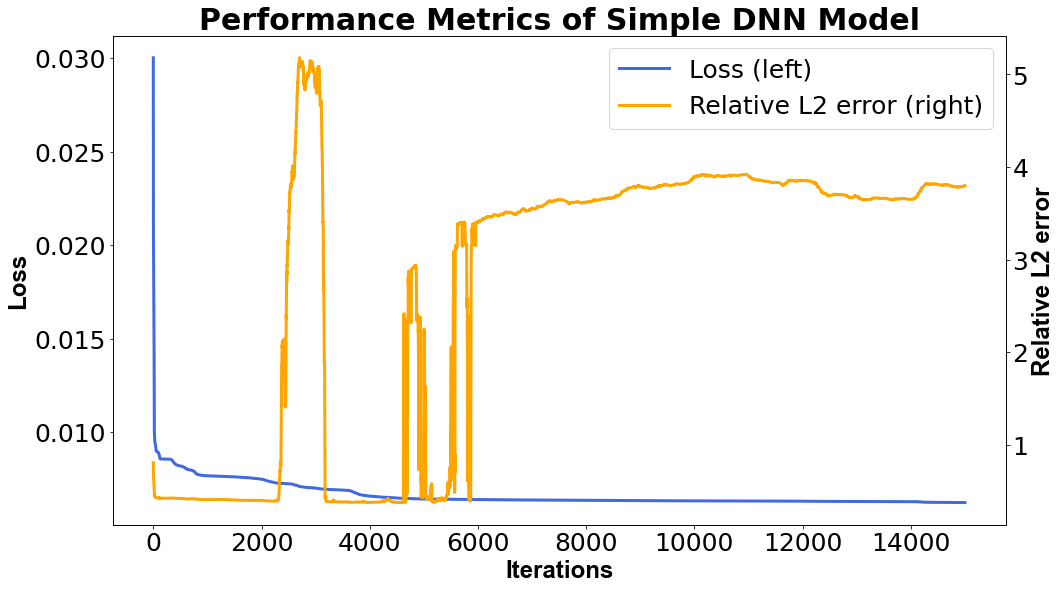

In [17]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax2 = ax1.twinx()
line1 = ax1.plot(loss_record, linewidth = '3', color = "royalblue", label='Loss (left)')
line2 = ax2.plot(l2_record, linewidth = '3', color = "orange", label='Relative L2 error (right)')
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')
plt.title("Performance Metrics of Simple DNN Model", fontsize=30, fontweight="bold")
ax1.set_xlabel("Iterations", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Loss", fontsize=24, fontname = 'Arial', fontweight="bold")
ax2.set_ylabel("Relative L2 error", fontsize=24, fontname = 'Arial', fontweight="bold")
fig.set_size_inches(16, 9)

# 전체 그리드 비교

In [18]:
u_pred = PINN.evaluate(X_u_grid)
u_pred = np.reshape(u_pred,usol.shape,order='F')

y_test = usol
y_pred = u_pred

error_vec = np.linalg.norm((y_test-y_pred),2)/np.linalg.norm(y_test,2)

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

MAE =  1.8528189973304636
MSE =  123.25215391957462
RMSE =  11.101898662822258
L2 relative error = 108.6666705436782
--------------------------------------------------


Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

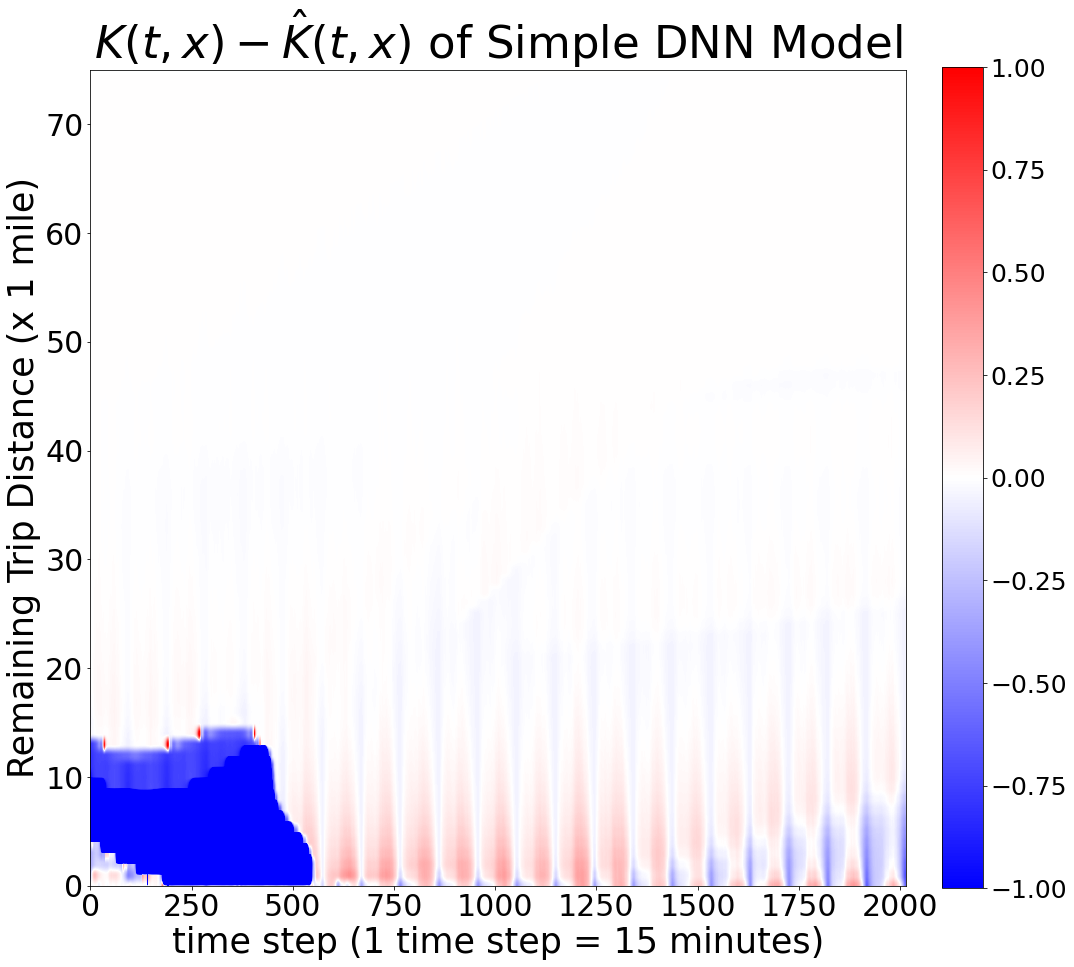

In [ ]:
K_array = np.array(u_pred)
K_array = (usol - K_array)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$K(t,x)- \hat{K}(t,x)$' ' of Simple DNN Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

In [ ]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax1.plot(K_array.flatten(), linewidth = '1', color = "royalblue", label='Loss (left)')
plt.title("Observed data - Estimated data(w/ Physics)", fontsize=30, fontweight="bold")
ax1.set_xlabel("Data", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Observed data - Estimated data", fontsize=24, fontname = 'Arial', fontweight="bold")

fig.set_size_inches(16, 9)